<center> Business Decisions Project

<center> By

<center> Saar Golan

# Introduction

I am an analyst with a big online store.  
Together with the marketing department, we compiled a list of hypotheses that may help boost revenue.

# Project objectives

* Prioritize the hypotheses
* Launch an A/B test
* Analyze the results. 

# Description of the data

**The Hypotheses table (data on hypotheses):**
* Hypotheses — brief descriptions of the hypotheses
* Reach — user reach, on a scale of one to ten
* Impact — impact on users, on a scale of one to ten
* Confidence — confidence in the hypothesis, on a scale of one to ten
* Effort — the resources required to test a hypothesis, on a scale of one to ten.  
  The higher the Effort value, the more resource-intensive the test.

**The orders table (data on orders):**
* transactionId — order identifier
* visitorId — identifier of the user who placed the order
* date — of the order
* revenue — from the order
* group — the A/B test group that the user belongs to

**The visits table (data on visits):**
* date — date
* group — A/B test group
* visits — the number of visits on the date specified in the A/B test group specified

# General set-up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
from functools import reduce
import seaborn as sns
import math
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1) #was -1, None
plt.rcParams.update({'figure.max_open_warning': 0})


#Install jupyter extensions and packages

!pip install plotly==5.5.0
!pip install -U seaborn

'''
#!pip install jupyterthemes
#!pip install --upgrade jupyterthemes
#!jt -t monokai -T -T -kl
#install theme and enable the toolbar, filename, logo, kernel
#!jt -r #install original theme

!pip install jupyter_contrib_nbextensions
!jupyter nbextension enable toc2/main
!jupyter nbextension enable varInspector/main
!jupyter nbextension enable execute_time/ExecuteTime
!jupyter nbextension enable highlighter/highlighter
!jupyter nbextension enable move_selected_cells/main
#!pip install jupyter_latex_envs [--user][--upgrade]
#!jupyter nbextension install --py latex_envs [--user|--sys-prefix|--system]
#!jupyter nbextension enable --py latex_envs [--user|--sys-prefix|--system]
'''

#Output all cell commands
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/  
#http://www.xavierdupre.fr/app/pymyinstall/helpsphinx/blog/2016/2016-10-29-nbextensions.html  
#https://reposhub.com/python/miscellaneous/lckr-jupyterlab-variableInspector.html  
#https://stackoverflow.com/questions/36786722/how-to-display-full-output-in-jupyter-not-only-last-result

C:\Users\fillorent\AppData\Roaming\Python\Python38\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
<ipython-input-1-60ad0b1161bc>:17: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1) #was -1, None


You should consider upgrading via the 'c:\users\fillorent\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\fillorent\anaconda3\python.exe -m pip install --upgrade pip' command.


# Step 1. Download the data and prepare it for analysis

Here, I will:
* Store the data on hypotheses, visits and orders using proper variables.  
* Optimize the data for analysis.  
* Make sure each column contains the correct data type.

## Import the data

In [2]:
try:
    hypotheses = pd.read_csv('hypotheses_us.csv', sep=';',
                         dtype={'Hypothesis': 'object', 'Reach': 'int32', 'Impact': 'int32',
                                'Confidence': 'int32', 'Effort': 'int32'})                 
    orders = pd.read_csv('orders_us.csv',
                         dtype={'revenue': 'float32', 'group': 'category'},
                         parse_dates=['date'])
    visits = pd.read_csv('visits_us.csv',
                        dtype={'group': 'category', 'visits': 'uint16'},
                        parse_dates=['date'])
except:
    hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep=';',
                         dtype={'Hypothesis': 'object', 'Reach': 'int32', 'Impact': 'int32',
                                'Confidence': 'int32', 'Effort': 'int32'})
    orders = pd.read_csv('/datasets/orders_us.csv',
                         dtype={'revenue': 'float32', 'group': 'category'},
                         parse_dates=['date'])
    visits = pd.read_csv('/datasets/visits_us.csv',
                        dtype={'group': 'category', 'visits': 'uint32'},
                        parse_dates=['date'])

# technically, an int8 and a float16 would be sufficient for the hypotheses columns and orders.revenue
# , respectively, but then pandas cannot calculate
# mean and sum because it has insufficient memory allocation...

# https://thispointer.com/pandas-read-csv-file-to-dataframe-with-custom-delimiter-in-python/

## Examine and preprocess the data

### General examination

Define a function to examine data:

In [3]:
def examine(fname):
    print('\n***************\n head:\n', fname.head())
    print('\n***************\n tail:\n', fname.tail())
    print('\n***************\n info:\n', fname.info(memory_usage='deep'))
    print('\n***************\n describe:\n', fname.describe())
    
    # Exploring categorical variables
    for column in fname.select_dtypes(exclude=['number','datetime64[ns]']).columns:
        print('===============', column, '===============')
        print(fname[column].value_counts())        
        print('Total No. of values:' , fname[column].value_counts().count())
        print('\n')

#https://stackoverflow.com/questions/29803093/check-which-columns-in-dataframe-are-categorical  

In [4]:
examine(hypotheses)


***************
 head:
                                                                                                                Hypothesis  \
0  Add two new channels for attracting traffic. This will bring 30% more users                                              
1  Launch your own delivery service. This will shorten delivery time                                                        
2  Add product recommendation blocks to the store's site. This will increase conversion and average purchase size           
3  Change the category structure. This will increase conversion since users will find the products they want more quickly   
4  Change the background color on the main page. This will increase user engagement                                         

   Reach  Impact  Confidence  Effort  
0  3      10      8           6       
1  2      5       4           10      
2  8      3       7           3       
3  8      3       3           8       
4  3      1       1          

In [5]:
hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


We have 9 potential hypotheses to prioritize.  
They all have a wide range of paramters (Reach, Impact...).  
We will calculate their scores below.

In [6]:
examine(orders)


***************
 head:
    transactionId   visitorId       date     revenue group
0  3667963787     3312258926 2019-08-15  30.400000   B   
1  2804400009     3642806036 2019-08-15  15.200000   B   
2  2961555356     4069496402 2019-08-15  10.200000   A   
3  3797467345     1196621759 2019-08-15  155.100006  B   
4  2282983706     2322279887 2019-08-15  40.500000   B   

***************
 tail:
       transactionId   visitorId       date      revenue group
1192  2662137336     3733762160 2019-08-14  100.800003   B   
1193  2203539145     370388673  2019-08-14  50.099998    A   
1194  1807773912     573423106  2019-08-14  165.300003   A   
1195  1947021204     1614305549 2019-08-14  5.500000     A   
1196  3936777065     2108080724 2019-08-15  3120.100098  B   
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  11

In [7]:
examine(visits)


***************
 head:
         date group  visits
0 2019-08-01  A     719   
1 2019-08-02  A     619   
2 2019-08-03  A     507   
3 2019-08-04  A     717   
4 2019-08-05  A     756   

***************
 tail:
          date group  visits
57 2019-08-27  B     720   
58 2019-08-28  B     654   
59 2019-08-29  B     531   
60 2019-08-30  B     490   
61 2019-08-31  B     718   
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     category      
 2   visits  62 non-null     uint32        
dtypes: category(1), datetime64[ns](1), uint32(1)
memory usage: 1.0 KB

***************
 info:
 None

***************
 describe:
            visits
count  62.000000 
mean   607.290323
std    114.400560
min    361.000000
25%    534.000000
50%    624.500000
75%    710.500000
max    770.000000
======

Investigate time span:

In [8]:
print(orders['date'].min())
print(orders['date'].max())
print(visits['date'].min())
print(visits['date'].max())

2019-08-01 00:00:00
2019-08-31 00:00:00
2019-08-01 00:00:00
2019-08-31 00:00:00


Examine data distributions:

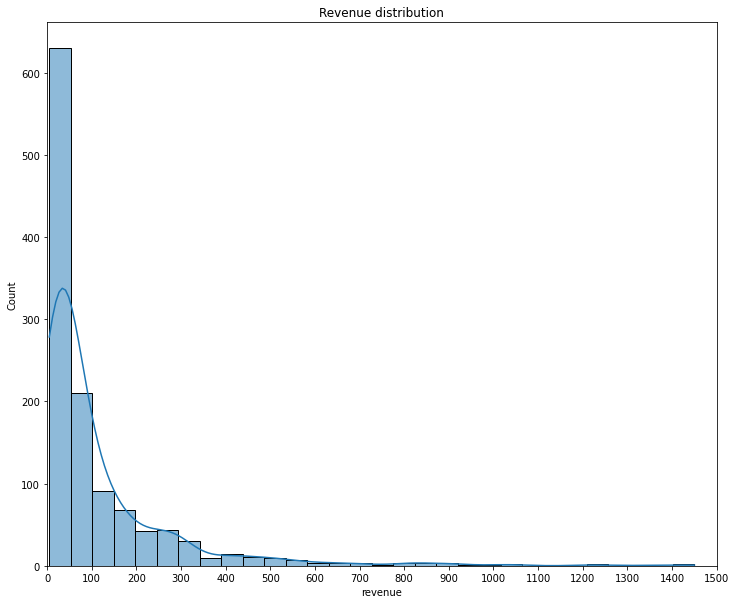

In [9]:
fig, ax = plt.subplots()
hisplot = sns.histplot(data = orders[orders['revenue'] < 1500], x = "revenue", bins=30, kde=True)
x1 = ax.set_xlim(0,1500)
x2 = ax.set_xticks(range(0,1600,100))
x99 = hisplot.set_title("Revenue distribution")
fig.set_size_inches(12,10)
plt.show()

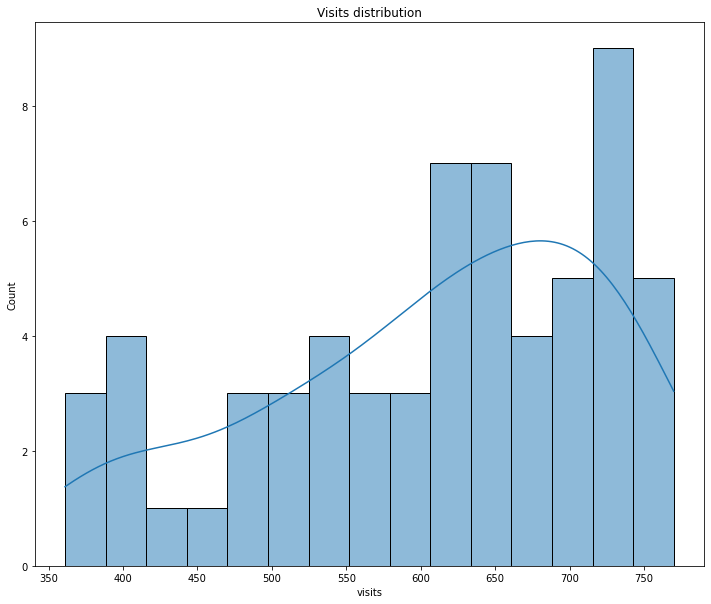

In [10]:
fig, ax = plt.subplots()
hisplot = sns.histplot(data = visits, x = "visits", bins=15, kde=True)
#x1 = ax.set_xlim(0,1500)
#x2 = ax.set_xticks(range(0,1600,100))
x99 = hisplot.set_title("Visits distribution")
fig.set_size_inches(12,10)
plt.show()

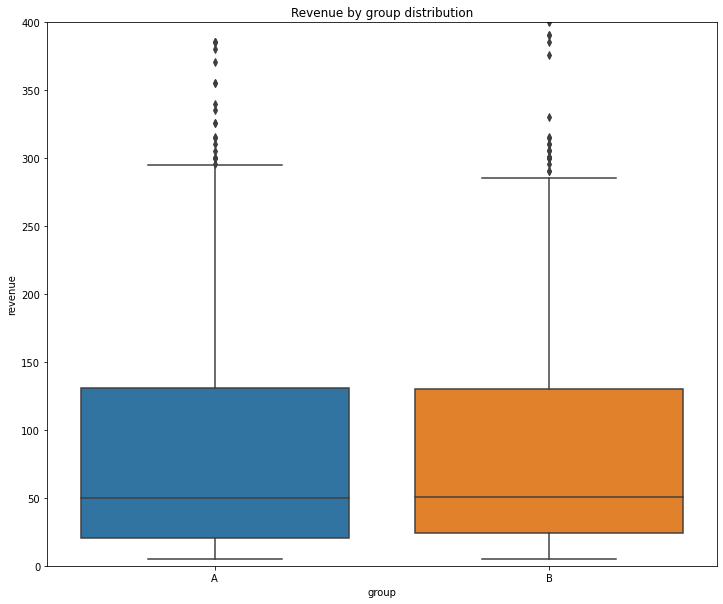

In [11]:
fig, ax = plt.subplots()
box_plot = sns.boxplot(x="group", y="revenue", data=orders)
#swarm_plot = sns.swarmplot(x="group", y="revenue", data=orders, size=2, color=".25")
y1 = ax.set_ylim(0,400) #leaving some outliers out so we can clearly see the graph
x99 = box_plot.set_title("Revenue by group distribution")
fig.set_size_inches(12,10)
plt.show()

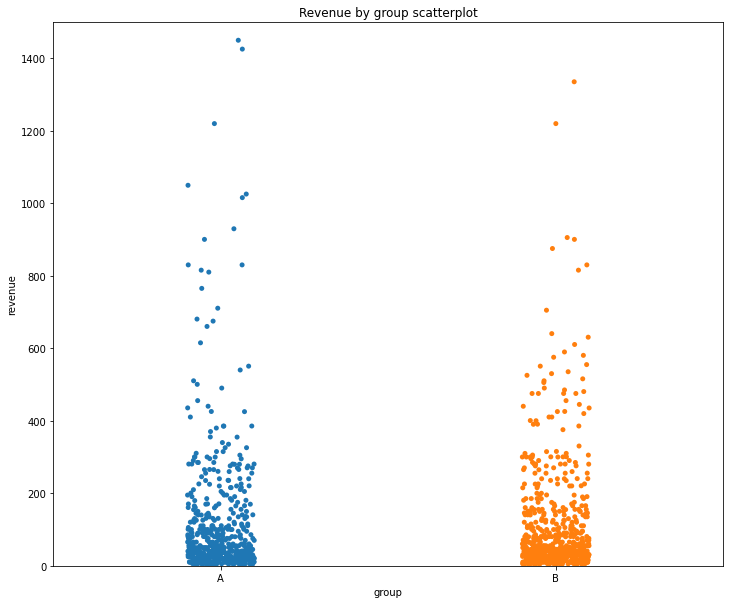

In [12]:
fig, ax = plt.subplots()
box_plot = sns.stripplot(x="group", y="revenue", data=orders)
#swarm_plot = sns.swarmplot(x="group", y="revenue", data=orders, size=2, color=".25")
y1 = ax.set_ylim(0,1500) #leaving some outliers out so we can clearly see the graph
x99 = box_plot.set_title("Revenue by group scatterplot")
fig.set_size_inches(12,10)
plt.show()

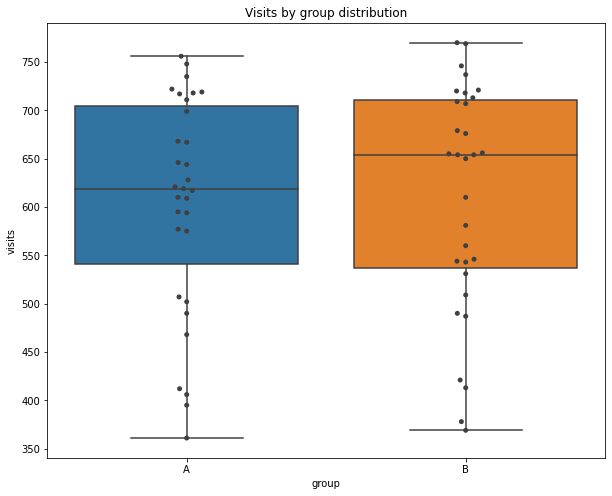

In [13]:
fig, ax = plt.subplots()
box_plot = sns.boxplot(x="group", y="visits", data=visits)
swarm_plot = sns.swarmplot(x="group", y="visits", data=visits, color=".25")
#y1 = ax.set_ylim(0,1500)
x99 = box_plot.set_title("Visits by group distribution")
fig.set_size_inches(10,8)
plt.show()

### Temporal examination

Creating data segmentation for temporal analysis. 

In [14]:
visits['day_of_week']  = visits['date'].dt.dayofweek #The day of the week with Monday=0, Sunday=6.
visits['week']  = visits['date'].astype('datetime64[W]') # The week
orders['day_of_week']  = orders['date'].dt.dayofweek
orders['week']  = orders['date'].astype('datetime64[W]')

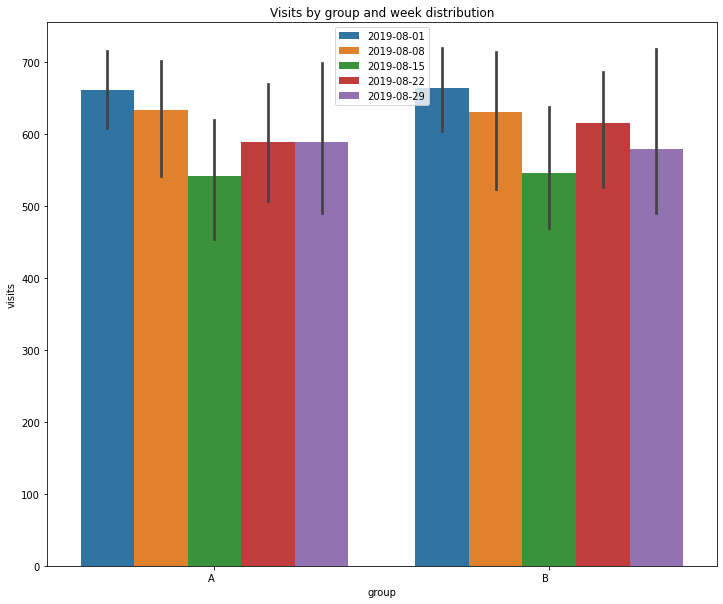

In [15]:
# Draw a nested barplot by group and week
fig, ax = plt.subplots()
l_dates = visits.week.dt.strftime('%Y-%m-%d').sort_values().unique()
box_plot = sns.barplot(x = visits["group"],
                       y = visits["visits"],
                       hue = "week",
                       hue_order=l_dates,
                       data= visits)          
#x_dates = visits.week.dt.strftime('%Y-%m-%d').sort_values().unique()
x_dates = visits.group.sort_values().unique()
x1 = ax.set_xticklabels(labels=x_dates, ha='right') #rotation=45, 
l1 = plt.legend(loc='upper left', labels=l_dates)
hands, labs = ax.get_legend_handles_labels()
l2 = plt.legend(handles=hands, labels=labs)
x99 = box_plot.set_title("Visits by group and week distribution")
fig.set_size_inches(12,10)
plt.show()

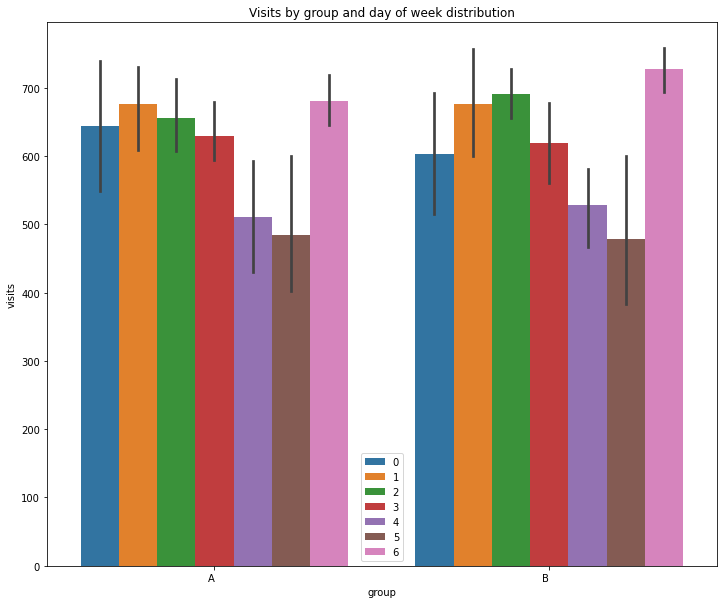

In [16]:
# Draw a nested barplot by group and day of week
fig, ax = plt.subplots()
#l_dates = visits.week.dt.strftime('%Y-%m-%d').sort_values().unique()
l_dates = visits.day_of_week.sort_values().unique()
box_plot = sns.barplot(x = visits["group"],
                       y = visits["visits"],
                       hue = "day_of_week",
                       hue_order=l_dates,
                       data= visits)          
#x_dates = visits.week.dt.strftime('%Y-%m-%d').sort_values().unique()
x_dates = visits.group.sort_values().unique()
x1 = ax.set_xticklabels(labels=x_dates, ha='right')  #, rotation=45
l1 = plt.legend(loc='upper left', labels=l_dates)
hands, labs = ax.get_legend_handles_labels()
l2 = plt.legend(handles=hands, labels=labs)
x99 = box_plot.set_title("Visits by group and day of week distribution")
fig.set_size_inches(12,10)
plt.show()

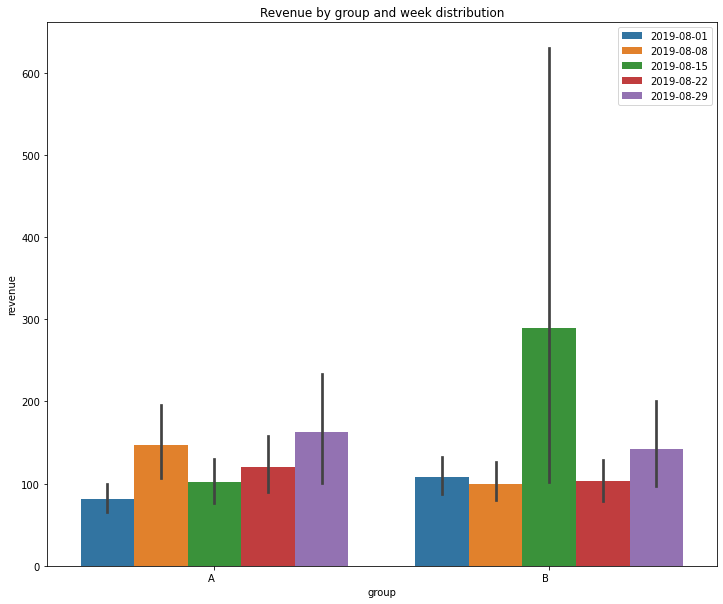

In [17]:
# Draw a nested barplot by group and week
fig, ax = plt.subplots()
l_dates = orders.week.dt.strftime('%Y-%m-%d').sort_values().unique()
box_plot = sns.barplot(x = orders["group"],
                       y = orders["revenue"],
                       hue = "week",
                       hue_order=l_dates,
                       data= orders)          
#x_dates = visits.week.dt.strftime('%Y-%m-%d').sort_values().unique()
x_dates = orders.group.sort_values().unique()
x1 = ax.set_xticklabels(labels=x_dates, ha='right') #, rotation=45
l1 = plt.legend(loc='upper left', labels=l_dates)
hands, labs = ax.get_legend_handles_labels()
l2 = plt.legend(handles=hands, labels=labs)
x99 = box_plot.set_title("Revenue by group and week distribution")
fig.set_size_inches(12,10)
plt.show()

In [18]:
orders.query('week == "2019-08-15" & group == "B" & revenue > 500')

,transactionId,visitorId,date,revenue,group,day_of_week,week
60,1421016313,4256040402,2019-08-16,875.500000,B,4,2019-08-15
78,773663763,3288820196,2019-08-16,630.799988,B,4,2019-08-15
425,590470918,1920142716,2019-08-19,19920.400391,B,0,2019-08-15
527,1570513684,2837914161,2019-08-19,515.900024,B,0,2019-08-15
751,348143148,689129267,2019-08-20,575.500000,B,1,2019-08-15
1196,3936777065,2108080724,2019-08-15,3120.100098,B,3,2019-08-15


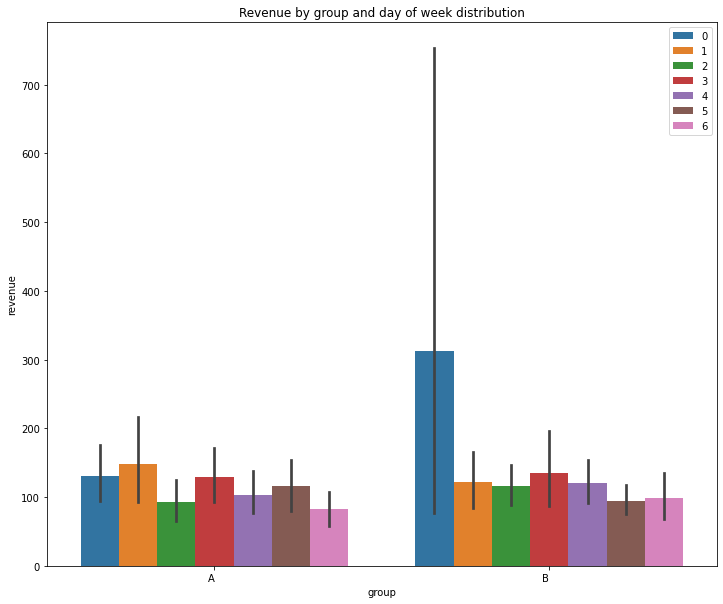

In [19]:
# Draw a nested barplot by group and day of week
fig, ax = plt.subplots()
#l_dates = visits.week.dt.strftime('%Y-%m-%d').sort_values().unique()
l_dates = orders.day_of_week.sort_values().unique()
box_plot = sns.barplot(x = orders["group"],
                       y = orders["revenue"],
                       hue = "day_of_week",
                       hue_order=l_dates,
                       data= orders)          
#x_dates = visits.week.dt.strftime('%Y-%m-%d').sort_values().unique()
x_dates = orders.group.sort_values().unique()
x1 = ax.set_xticklabels(labels=x_dates, ha='right')  #, rotation=45
l1 = plt.legend(loc='upper left', labels=l_dates)
hands, labs = ax.get_legend_handles_labels()
l2 = plt.legend(handles=hands, labels=labs)
x99 = box_plot.set_title("Revenue by group and day of week distribution")
fig.set_size_inches(12,10)
plt.show()

In [20]:
orders.query('day_of_week == 0 & group == "B" & revenue > 500')

,transactionId,visitorId,date,revenue,group,day_of_week,week
425,590470918,1920142716,2019-08-19,19920.400391,B,0,2019-08-15
527,1570513684,2837914161,2019-08-19,515.900024,B,0,2019-08-15
563,922638597,935349363,2019-08-26,550.900024,B,0,2019-08-22
1087,324171086,3590655705,2019-08-12,610.700012,B,0,2019-08-08
1096,3075787818,3062433592,2019-08-12,505.700012,B,0,2019-08-08


### Duplicates

In [21]:
visits.duplicated().sum()
orders.duplicated().sum()
#df.loc[df.duplicated(), :]

0

0

### Outliers

In [22]:
visits.visits.sort_values(ascending=False).head(15)

34    770
43    769
4     756
12    748
44    746
48    737
13    735
25    722
41    721
57    720
0     719
61    718
10    718
3     717
31    713
Name: visits, dtype: uint32

In [23]:
orders.revenue.sort_values(ascending=False).head(15)

425     19920.400391
1196    3120.100098 
858     1450.199951 
1136    1425.800049 
744     1335.599976 
662     1220.199951 
682     1220.199951 
743     1050.000000 
1103    1025.800049 
1099    1015.900024 
949     930.000000  
940     905.799988  
873     900.700012  
1029    900.700012  
60      875.500000  
Name: revenue, dtype: float32

### Bad traffic routing

Make sure to preprocess the data.  
There might be mistakes in the original datasets.  
For example, some of the visitors might have gotten into both group A and group B.

Show users with more than one group:

In [24]:
bad_traffic = orders.groupby(['visitorId'])['group'].nunique().reset_index()
bad_traffic = bad_traffic [bad_traffic['group'] > 1]
bad_traffic.info()
bad_traffic.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 2 to 1026
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   visitorId  58 non-null     int64
 1   group      58 non-null     int64
dtypes: int64(2)
memory usage: 1.4 KB


,visitorId,group
2,8300375,2
44,199603092,2
51,232979603,2
55,237748145,2
66,276558944,2


Examine the transactions performed by these users:

In [25]:
bad_transactions = orders[orders['visitorId'].isin(bad_traffic['visitorId'])].sort_values(by=['visitorId', 'date'])
bad_transactions.head(20)

,transactionId,visitorId,date,revenue,group,day_of_week,week
71,3679129301,8300375,2019-08-01,165.699997,B,3,2019-08-01
703,4293855558,8300375,2019-08-07,30.500000,A,2,2019-08-01
246,437656952,199603092,2019-08-02,55.700001,B,4,2019-08-01
1102,1941707234,199603092,2019-08-12,100.000000,A,0,2019-08-08
26,2223239646,199603092,2019-08-15,55.700001,A,3,2019-08-15
134,62794304,199603092,2019-08-22,110.300003,A,3,2019-08-22
823,2971973105,199603092,2019-08-27,45.900002,A,1,2019-08-22
1009,2670069237,232979603,2019-08-31,45.599998,B,5,2019-08-29
1013,83566152,232979603,2019-08-31,5.900000,A,5,2019-08-29
1097,3357467820,237748145,2019-08-12,10.200000,A,0,2019-08-08


We can see that some visitors (e.g., 199603092) perform even 5 transactions.  
We get 181 cases (I used the count() method to figure that out) of double routing out of 1197.  
This is 15% of the data.  
It is better to remove the users who got into both groups because we don't know for sure what version they saw when (maybe A and B groups got mixed?) and that can skew the data and give us a false results.  

Another approach is to try and save some of the data. by claiming that the first time users are exposed to a group variation (be that A or B) they are not biased. Only the second time around, when they encounter the alternative, we cannot rely on their decision. Even this only happens if they encounter a test variation that is different from their original version. For example:  
* visitor 8300375 encountered option A on 2019-08-07 six days after encountering option B.  
So, in this case, option B could be reliable, but option A is not.
* visitor 199603092 encountered option B on 2019-08-02 and then followed to visit our store 4 more times through option A. So the original option B could be reliable while all subsequent group A visits are not reliable for an A/B test (because he/she is already biased by configuration B).  
  
However, to adopt this approach, we must be absolutely sure that for these 'double-booked' users the groups were not mixed to begin with and every group A is indeed an A just as every group B is indeed a B.  
Unfortunately we cannot be sure.  
Let's investigate what would be the gain in data if we adopt this approach and keep the entries relating to first orders and following orders of the same group untill the user experienced a group switch:

Find the date of the first visits attributed to each group:

In [26]:
first_visit_A = orders[orders['group'] == 'A'].groupby(['visitorId'])['date'].min().reset_index()
first_visit_A.columns = ['visitorId', 'first_visit_A']
first_visit_A.head()
first_visit_A.info()

,visitorId,first_visit_A
0,8300375,2019-08-07
1,11685486,2019-08-23
2,54447517,2019-08-08
3,66685450,2019-08-13
4,78758296,2019-08-15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   visitorId      503 non-null    int64         
 1   first_visit_A  503 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 8.0 KB


In [27]:
first_visit_B = orders[orders['group'] == 'B'].groupby(['visitorId'])['date'].min().reset_index()
first_visit_B.columns = ['visitorId', 'first_visit_B']
first_visit_B.head()
first_visit_B.info()

,visitorId,first_visit_B
0,5114589,2019-08-16
1,6958315,2019-08-04
2,8300375,2019-08-01
3,39475350,2019-08-08
4,47206413,2019-08-10


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586 entries, 0 to 585
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   visitorId      586 non-null    int64         
 1   first_visit_B  586 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 9.3 KB


In [28]:
orders = orders.merge(first_visit_A, how = 'left', on = ['visitorId'])
orders = orders.merge(first_visit_B, how = 'left', on = ['visitorId'])
orders.head(15)
orders.info()

,transactionId,visitorId,date,revenue,group,day_of_week,week,first_visit_A,first_visit_B
0,3667963787,3312258926,2019-08-15,30.400000,B,3,2019-08-15,NaT,2019-08-15
1,2804400009,3642806036,2019-08-15,15.200000,B,3,2019-08-15,NaT,2019-08-15
2,2961555356,4069496402,2019-08-15,10.200000,A,3,2019-08-15,2019-08-15,2019-08-12
3,3797467345,1196621759,2019-08-15,155.100006,B,3,2019-08-15,NaT,2019-08-15
4,2282983706,2322279887,2019-08-15,40.500000,B,3,2019-08-15,NaT,2019-08-15
5,182168103,935554773,2019-08-15,35.000000,B,3,2019-08-15,NaT,2019-08-15
6,398296753,2900797465,2019-08-15,30.600000,B,3,2019-08-15,NaT,2019-08-15
7,2626614568,78758296,2019-08-15,20.100000,A,3,2019-08-15,2019-08-15,NaT
8,1576988021,295230930,2019-08-15,215.899994,A,3,2019-08-15,2019-08-15,NaT
9,1506739906,1882260405,2019-08-15,30.500000,B,3,2019-08-15,NaT,2019-08-15


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1197 entries, 0 to 1196
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float32       
 4   group          1197 non-null   category      
 5   day_of_week    1197 non-null   int64         
 6   week           1197 non-null   datetime64[ns]
 7   first_visit_A  649 non-null    datetime64[ns]
 8   first_visit_B  729 non-null    datetime64[ns]
dtypes: category(1), datetime64[ns](4), float32(1), int64(3)
memory usage: 80.8 KB


Let us define the double booked visitors:

In [29]:
double_book = orders[
    ((~np.isnat(orders['first_visit_A'])) & (~np.isnat(orders['first_visit_B'])))
    & (((orders['date'] >= orders['first_visit_A']) & (orders['date'] >= orders['first_visit_B']))
       | (orders['first_visit_A'] == orders['first_visit_B']))
]

#explanation (same as rows above):
# Double booking is when:
# 1. we have both A and B group visits (they are not null)
# 2. the order is later or on the same date as both group visits
#    or that both first group visits occur on the same day
 
#https://stackoverflow.com/questions/38509538/numpy-checking-if-a-value-is-nat

In [30]:
double_book.sort_values(by=['visitorId', 'date']).head(30)

,transactionId,visitorId,date,revenue,group,day_of_week,week,first_visit_A,first_visit_B
703,4293855558,8300375,2019-08-07,30.500000,A,2,2019-08-01,2019-08-07,2019-08-01
1102,1941707234,199603092,2019-08-12,100.000000,A,0,2019-08-08,2019-08-12,2019-08-02
26,2223239646,199603092,2019-08-15,55.700001,A,3,2019-08-15,2019-08-12,2019-08-02
134,62794304,199603092,2019-08-22,110.300003,A,3,2019-08-22,2019-08-12,2019-08-02
823,2971973105,199603092,2019-08-27,45.900002,A,1,2019-08-22,2019-08-12,2019-08-02
1009,2670069237,232979603,2019-08-31,45.599998,B,5,2019-08-29,2019-08-31,2019-08-31
1013,83566152,232979603,2019-08-31,5.900000,A,5,2019-08-29,2019-08-31,2019-08-31
27,1630050528,237748145,2019-08-15,120.199997,B,3,2019-08-15,2019-08-12,2019-08-15
41,2594268419,237748145,2019-08-15,20.799999,A,3,2019-08-15,2019-08-12,2019-08-15
590,3702128013,237748145,2019-08-20,20.799999,A,1,2019-08-15,2019-08-12,2019-08-15


TransactionId is unique so we can use it now to slice:

In [31]:
orders['transactionId'].nunique()

1197

In [32]:
orders_first = orders[~orders['transactionId'].isin(double_book['transactionId'])]

In [33]:
orders_first.sort_values(by=['visitorId', 'date']).head(25)
orders_first.sort_values(by=['visitorId', 'date']).tail(25)

,transactionId,visitorId,date,revenue,group,day_of_week,week,first_visit_A,first_visit_B
56,900025958,5114589,2019-08-16,10.800000,B,4,2019-08-15,NaT,2019-08-16
573,1887336629,6958315,2019-08-04,25.900000,B,6,2019-08-01,NaT,2019-08-04
71,3679129301,8300375,2019-08-01,165.699997,B,3,2019-08-01,2019-08-07,2019-08-01
233,797272237,11685486,2019-08-23,100.400002,A,4,2019-08-22,2019-08-23,NaT
912,437876380,39475350,2019-08-08,65.400002,B,3,2019-08-08,NaT,2019-08-08
924,3778001764,47206413,2019-08-10,15.200000,B,5,2019-08-08,NaT,2019-08-10
951,965979600,48147722,2019-08-22,20.799999,B,3,2019-08-22,NaT,2019-08-22
1003,2765619353,54447517,2019-08-08,5.000000,A,3,2019-08-08,2019-08-08,NaT
567,2952636658,56960363,2019-08-09,25.900000,B,4,2019-08-08,NaT,2019-08-09
1126,448493494,66685450,2019-08-13,125.900002,A,1,2019-08-08,2019-08-13,NaT


,transactionId,visitorId,date,revenue,group,day_of_week,week,first_visit_A,first_visit_B
680,2083889130,4176813035,2019-08-20,30.799999,B,1,2019-08-15,NaT,2019-08-20
1075,4261512099,4178309188,2019-08-12,50.799999,B,0,2019-08-08,NaT,2019-08-12
361,2400978083,4181076848,2019-08-06,260.000000,B,1,2019-08-01,NaT,2019-08-06
409,822092266,4186744110,2019-08-03,10.800000,B,5,2019-08-01,NaT,2019-08-03
1167,3757656646,4186807279,2019-08-14,80.800003,A,2,2019-08-08,2019-08-14,2019-08-21
659,3615982016,4194288377,2019-08-26,75.300003,B,0,2019-08-22,NaT,2019-08-26
850,3834417582,4205543768,2019-08-05,45.099998,B,0,2019-08-01,NaT,2019-08-05
817,1460586653,4213333413,2019-08-21,5.300000,A,2,2019-08-15,2019-08-21,NaT
1012,3141224116,4216089391,2019-08-31,70.500000,B,5,2019-08-29,NaT,2019-08-31
610,2461347779,4223733735,2019-08-04,45.500000,A,6,2019-08-01,2019-08-04,NaT


Now, when we have cases of 'double-booking', we are left only with the visitors transactions attributed to a single group (the first one).

In [34]:
examine(orders_first)


***************
 head:
    transactionId   visitorId       date     revenue group  day_of_week  \
0  3667963787     3312258926 2019-08-15  30.400000   B     3             
1  2804400009     3642806036 2019-08-15  15.200000   B     3             
3  3797467345     1196621759 2019-08-15  155.100006  B     3             
4  2282983706     2322279887 2019-08-15  40.500000   B     3             
5  182168103      935554773  2019-08-15  35.000000   B     3             

        week first_visit_A first_visit_B  
0 2019-08-15 NaT           2019-08-15     
1 2019-08-15 NaT           2019-08-15     
3 2019-08-15 NaT           2019-08-15     
4 2019-08-15 NaT           2019-08-15     
5 2019-08-15 NaT           2019-08-15     

***************
 tail:
       transactionId   visitorId       date      revenue group  day_of_week  \
1192  2662137336     3733762160 2019-08-14  100.800003   B     2             
1193  2203539145     370388673  2019-08-14  50.099998    A     2             
1194  1807773

Let us see what we receive when we remove all reference to 'double-booked' users:

In [35]:
orders = orders[~orders['transactionId'].isin(bad_transactions['transactionId'])]

In [36]:
examine(orders)


***************
 head:
    transactionId   visitorId       date     revenue group  day_of_week  \
0  3667963787     3312258926 2019-08-15  30.400000   B     3             
1  2804400009     3642806036 2019-08-15  15.200000   B     3             
3  3797467345     1196621759 2019-08-15  155.100006  B     3             
4  2282983706     2322279887 2019-08-15  40.500000   B     3             
5  182168103      935554773  2019-08-15  35.000000   B     3             

        week first_visit_A first_visit_B  
0 2019-08-15 NaT           2019-08-15     
1 2019-08-15 NaT           2019-08-15     
3 2019-08-15 NaT           2019-08-15     
4 2019-08-15 NaT           2019-08-15     
5 2019-08-15 NaT           2019-08-15     

***************
 tail:
       transactionId   visitorId       date      revenue group  day_of_week  \
1191  3592955527     608641596  2019-08-14  255.699997   B     2             
1192  2662137336     3733762160 2019-08-14  100.800003   B     2             
1193  2203539

So, when removing all 'double-booked' visitors we are left with 1016 rather than 1069 entries out of the original 1197.  
The additional 4.4% of the data is not worth the risk of using potentially wrong entries.  
[  I am so cheap :)  ]

In [37]:
(1069-1016)/1197*100

4.427736006683375

**To conclude, we can see that:**
* The gods of Data Science spared us from nulls 😉
* There were no duplicates in the data
* The orders amounts are typically low to moderate (with 21\% below 21\\$ and a median of ~50\\$) and present a distribution that is strongly skewed to the right by the presence of high revenue outliers reaching as high as 20000. 
* Group A presents much less orders than group B (468 vs. 548, we still did not study the avergae order size in depth but the two groups seem similar...) 
* Visits distribution presents no clear trend (also not between groups).
* The data spans one month (Aug. 2019) for both orders and visits.  
Aug. 2019 provides many unique days (see below) but nothing out of the ordinary like Christmass that should considerably bias traffic or orders patterns.
* The week of the month presents no significant effects on visits.
* Fridays and Saturdays present considerably less visits while Sundays present the most visits.
* Revenue does not highly depend on week with the exception of Aug. 15th for group B (two very high outlier revenue values exist there).
* Revenue does not highly depend on the day of the week with the exception of a single Monday for group B (a very high outlier revenue value exists there).
* Overall, we have two very extreme outliers for the revenue (above 3000)
* We had a traffic issue that some users were routed to both options (A and B) - approximately 15% of the traffic.  
We must forward this finding to web design/devop so they can correct the A/B platform.  
In this case we choose to keep only absolutely clean interactions where users belong oly to a single group with our online store interface.  
We lost about 10% of the orders data to this error.

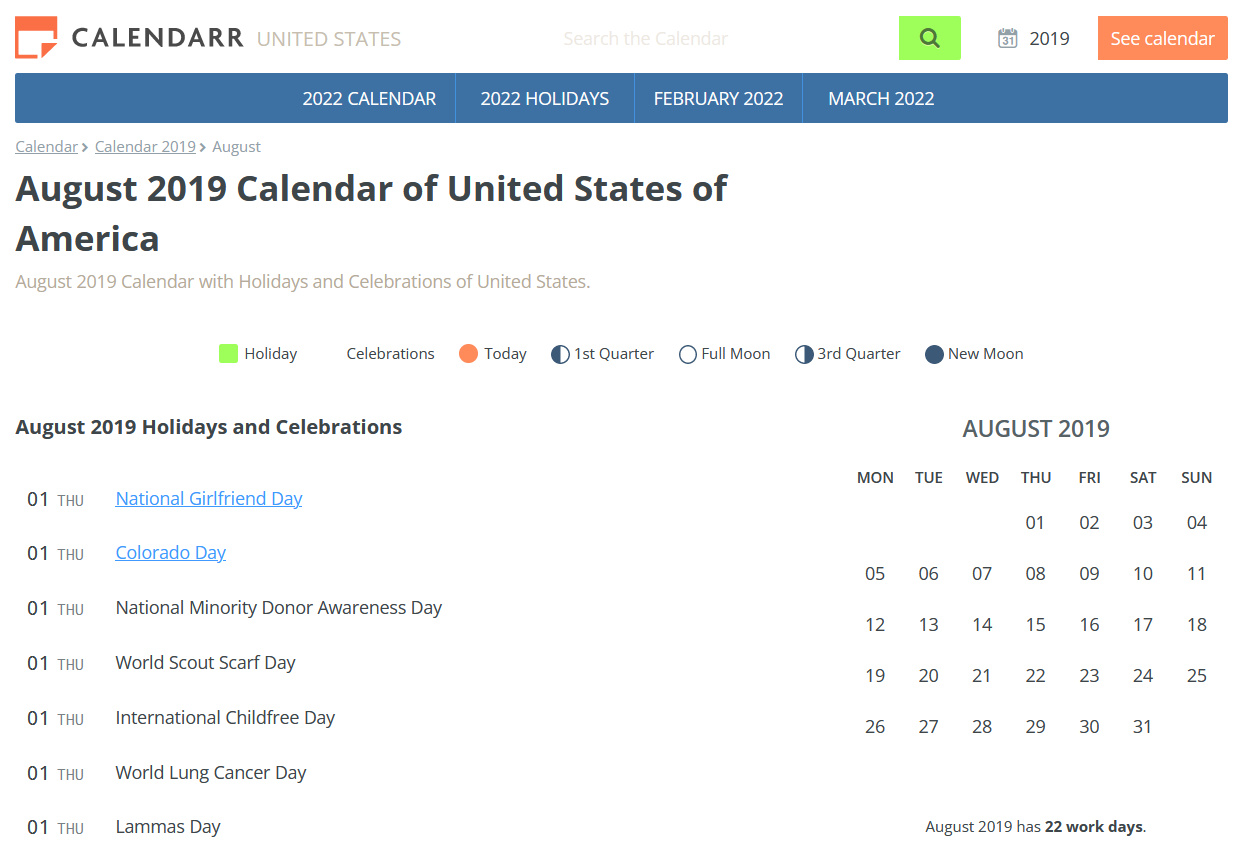


https://www.calendarr.com/united-states/calendar-august-2019/

# Part 1. Prioritizing Hypotheses

The file hypotheses_us.csv contains nine hypotheses on boosting an online store's revenue with Reach, Impact, Confidence, and Effort specified for each.

## ICE framework 

Apply the ICE framework to prioritize hypotheses. Sort them in descending order of priority.

ICE score = Impact x Confidence / Effort

In [38]:
hypotheses ['ICE_score'] = hypotheses ['Impact'] * hypotheses ['Confidence'] / hypotheses ['Effort'] 

In [39]:
hypotheses.sort_values(by = 'ICE_score', ascending = False)

,Hypothesis,Reach,Impact,Confidence,Effort,ICE_score
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.200000
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.333333
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.200000
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.000000
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.000000
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.000000
5,Add a customer review page. This will increase the number of orders,3,2,2,3,1.333333
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.125000
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.000000


## RICE framework 

Apply the RICE framework to prioritize hypotheses. Sort them in descending order of priority.

RICE score = Reach x Impact x Confidence / Effort

In [40]:
hypotheses ['RICE_score'] = hypotheses ['Reach'] * hypotheses ['Impact'] * hypotheses ['Confidence'] / hypotheses ['Effort'] 

In [41]:
hypotheses.sort_values(by = 'RICE_score', ascending = False)

,Hypothesis,Reach,Impact,Confidence,Effort,ICE_score,RICE_score
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.200000,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.000000,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.333333,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.000000,40.0
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.200000,16.2
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.125000,9.0
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.000000,4.0
5,Add a customer review page. This will increase the number of orders,3,2,2,3,1.333333,4.0
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.000000,3.0


## RICE vs. ICE comparison

Show how the prioritization of hypotheses changes when you use RICE instead of ICE.  
Provide an explanation for the changes.

We can see that hypothesis \#8 is first (the most promising) when using the ICE scale while hypothesis \#7 is first when using the RICE scale.  
Let us recall the meaning of each parameter:  
* Reach — how many users will be affected by the update you want to introduce
* Impact — how strongly this update will affect the users, their experience, and their satisfaction with the product
* Confidence — how sure you are that your product will affect them in this way
* Effort — how much will it cost to test the hypothesis

The RICE sacle is more general because it also considers each hypothesis reach.  
Hypothesis \#8 has high Impact and Confidence rates and a moderate Effort, so it scored high on the ICE scale.  
However, it has a very low Reach rate so it loses the lead when using the RICE scale.  
If it was my decision to make, I would go with hypothesis \#7 (the most promising one on the RICE scale, by a factor of >=2 compared with the following hypotheses 2 & 0).

# Part 2. A/B Test Analysis

We carried out the A/B test and got the results above.  
Let us now analyze the results.

## Graph cumulative revenue by group.

It is important to mention (and I did not mention it before) that we are assuming any order is attributed to the same instance/day the user visited our store.  
For instance, the user did not log in on 1.8, added something to the cart, and bought it 3 days later on 4.8.  
In other words, all revenue is analyzed by row.  
This is because we have no visitor/transaction information to analyze in the visits database.

Let us divide the orders data by group (much more convenient):  
(This comes instead of carrying a query or a slice throughout the entire project.  
The data is small so there are no real memory issues...)

In [42]:
ordersA = orders[orders['group'] == 'A'].sort_values(by=['date','transactionId']).reset_index()
ordersB = orders[orders['group'] == 'B'].sort_values(by=['date','transactionId']).reset_index()

Remark - here I assume that transactions are being numbered consecutively on the same date (I do not really know it for sure).

In [43]:
ordersA.head()
ordersB.head()

,index,transactionId,visitorId,date,revenue,group,day_of_week,week,first_visit_A,first_visit_B
0,147,52260954,3967698036,2019-08-01,20.200001,A,3,2019-08-01,2019-08-01,NaT
1,144,365058890,611059232,2019-08-01,45.299999,A,3,2019-08-01,2019-08-01,NaT
2,72,477940151,1422773200,2019-08-01,15.800000,A,3,2019-08-01,2019-08-01,NaT
3,141,602399015,3967698036,2019-08-01,5.600000,A,3,2019-08-01,2019-08-01,NaT
4,170,617930325,2785040378,2019-08-01,55.799999,A,3,2019-08-01,2019-08-01,NaT


,index,transactionId,visitorId,date,revenue,group,day_of_week,week,first_visit_A,first_visit_B
0,66,4919758,1217561296,2019-08-01,40.200001,B,3,2019-08-01,NaT,2019-08-01
1,100,804934578,1738775963,2019-08-01,50.799999,B,3,2019-08-01,NaT,2019-08-01
2,142,854120002,544963298,2019-08-01,25.900000,B,3,2019-08-01,NaT,2019-08-01
3,138,1403947326,1075551409,2019-08-01,10.000000,B,3,2019-08-01,NaT,2019-08-01
4,136,1578920557,680119828,2019-08-01,10.600000,B,3,2019-08-01,NaT,2019-08-01


In [44]:
ordersA ['cum_revenue'] = ordersA['revenue'].cumsum()
ordersB ['cum_revenue'] = ordersB['revenue'].cumsum()

In [45]:
ordersA.head()
ordersB.head()

,index,transactionId,visitorId,date,revenue,group,day_of_week,week,first_visit_A,first_visit_B,cum_revenue
0,147,52260954,3967698036,2019-08-01,20.200001,A,3,2019-08-01,2019-08-01,NaT,20.200001
1,144,365058890,611059232,2019-08-01,45.299999,A,3,2019-08-01,2019-08-01,NaT,65.500000
2,72,477940151,1422773200,2019-08-01,15.800000,A,3,2019-08-01,2019-08-01,NaT,81.300003
3,141,602399015,3967698036,2019-08-01,5.600000,A,3,2019-08-01,2019-08-01,NaT,86.900002
4,170,617930325,2785040378,2019-08-01,55.799999,A,3,2019-08-01,2019-08-01,NaT,142.699997


,index,transactionId,visitorId,date,revenue,group,day_of_week,week,first_visit_A,first_visit_B,cum_revenue
0,66,4919758,1217561296,2019-08-01,40.200001,B,3,2019-08-01,NaT,2019-08-01,40.200001
1,100,804934578,1738775963,2019-08-01,50.799999,B,3,2019-08-01,NaT,2019-08-01,91.000000
2,142,854120002,544963298,2019-08-01,25.900000,B,3,2019-08-01,NaT,2019-08-01,116.900002
3,138,1403947326,1075551409,2019-08-01,10.000000,B,3,2019-08-01,NaT,2019-08-01,126.900002
4,136,1578920557,680119828,2019-08-01,10.600000,B,3,2019-08-01,NaT,2019-08-01,137.500000


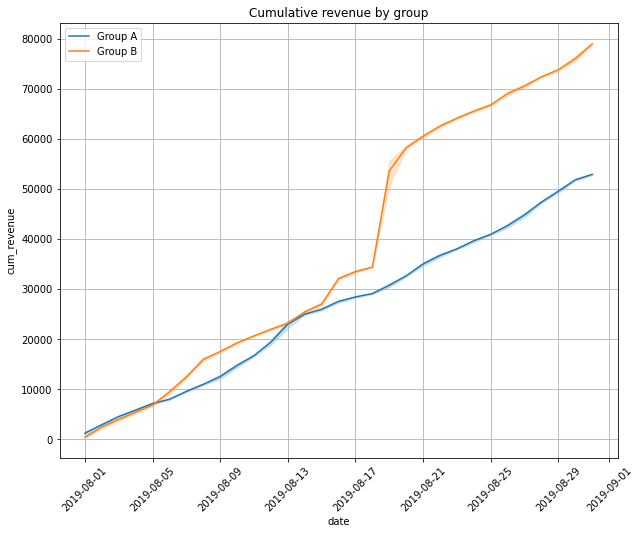

In [46]:
fig, ax = plt.subplots()
line_plotA = sns.lineplot(x = 'date', y = 'cum_revenue',data = ordersA, label = 'Group A')
line_plotB = sns.lineplot(x = 'date', y = 'cum_revenue',data = ordersB, label = 'Group B')
fig1 = fig.set_size_inches(10,8)
x1 = line_plotA.set_title("Cumulative revenue by group")
fig2 = plt.xticks(rotation=45)
fig3 = plt.grid()
plt.show()

#https://www.geeksforgeeks.org/rotate-axis-tick-labels-in-seaborn-and-matplotlib/

It appears that group B gains more revenue than group A.  
However, the slopes are generally identical - which means that both groups grow at roughly the same rate (with time).  
The main difference occurs between 17.8 and 21.8 and agrees with a known outlier order of ~20000 for group B (occurs on 19.8.2022).  
So, as of now, there is no reason to assume group B is more promising than group A.  
We need to clean anomalies first.

## Graph cumulative average order size by group.

Since each row is an order, the average order size is simply the cumulative revenue divided by the number of rows to this point.

In [47]:
ordersA['cum_orders'] = ordersA.index+1
ordersB['cum_orders'] = ordersB.index+1

In [48]:
ordersA.head()
ordersB.head()

,index,transactionId,visitorId,date,revenue,group,day_of_week,week,first_visit_A,first_visit_B,cum_revenue,cum_orders
0,147,52260954,3967698036,2019-08-01,20.200001,A,3,2019-08-01,2019-08-01,NaT,20.200001,1
1,144,365058890,611059232,2019-08-01,45.299999,A,3,2019-08-01,2019-08-01,NaT,65.500000,2
2,72,477940151,1422773200,2019-08-01,15.800000,A,3,2019-08-01,2019-08-01,NaT,81.300003,3
3,141,602399015,3967698036,2019-08-01,5.600000,A,3,2019-08-01,2019-08-01,NaT,86.900002,4
4,170,617930325,2785040378,2019-08-01,55.799999,A,3,2019-08-01,2019-08-01,NaT,142.699997,5


,index,transactionId,visitorId,date,revenue,group,day_of_week,week,first_visit_A,first_visit_B,cum_revenue,cum_orders
0,66,4919758,1217561296,2019-08-01,40.200001,B,3,2019-08-01,NaT,2019-08-01,40.200001,1
1,100,804934578,1738775963,2019-08-01,50.799999,B,3,2019-08-01,NaT,2019-08-01,91.000000,2
2,142,854120002,544963298,2019-08-01,25.900000,B,3,2019-08-01,NaT,2019-08-01,116.900002,3
3,138,1403947326,1075551409,2019-08-01,10.000000,B,3,2019-08-01,NaT,2019-08-01,126.900002,4
4,136,1578920557,680119828,2019-08-01,10.600000,B,3,2019-08-01,NaT,2019-08-01,137.500000,5


In [49]:
ordersA['avg_order_size'] = ordersA ['cum_revenue'] / ordersA['cum_orders']
ordersB['avg_order_size'] = ordersB ['cum_revenue'] / ordersB['cum_orders']

In [50]:
ordersA.head()
ordersB.head()

,index,transactionId,visitorId,date,revenue,group,day_of_week,week,first_visit_A,first_visit_B,cum_revenue,cum_orders,avg_order_size
0,147,52260954,3967698036,2019-08-01,20.200001,A,3,2019-08-01,2019-08-01,NaT,20.200001,1,20.200001
1,144,365058890,611059232,2019-08-01,45.299999,A,3,2019-08-01,2019-08-01,NaT,65.500000,2,32.750000
2,72,477940151,1422773200,2019-08-01,15.800000,A,3,2019-08-01,2019-08-01,NaT,81.300003,3,27.100001
3,141,602399015,3967698036,2019-08-01,5.600000,A,3,2019-08-01,2019-08-01,NaT,86.900002,4,21.725000
4,170,617930325,2785040378,2019-08-01,55.799999,A,3,2019-08-01,2019-08-01,NaT,142.699997,5,28.539999


,index,transactionId,visitorId,date,revenue,group,day_of_week,week,first_visit_A,first_visit_B,cum_revenue,cum_orders,avg_order_size
0,66,4919758,1217561296,2019-08-01,40.200001,B,3,2019-08-01,NaT,2019-08-01,40.200001,1,40.200001
1,100,804934578,1738775963,2019-08-01,50.799999,B,3,2019-08-01,NaT,2019-08-01,91.000000,2,45.500000
2,142,854120002,544963298,2019-08-01,25.900000,B,3,2019-08-01,NaT,2019-08-01,116.900002,3,38.966667
3,138,1403947326,1075551409,2019-08-01,10.000000,B,3,2019-08-01,NaT,2019-08-01,126.900002,4,31.725000
4,136,1578920557,680119828,2019-08-01,10.600000,B,3,2019-08-01,NaT,2019-08-01,137.500000,5,27.500000


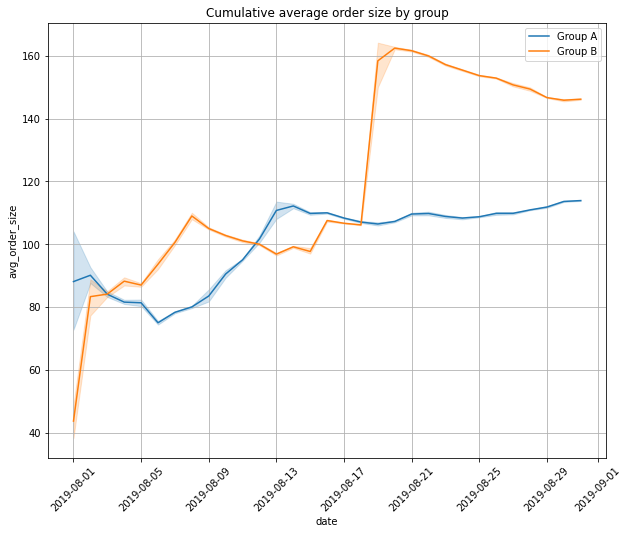

In [51]:
fig, ax = plt.subplots()
line_plotA = sns.lineplot(x = 'date', y = 'avg_order_size',data = ordersA, label = 'Group A')
line_plotB = sns.lineplot(x = 'date', y = 'avg_order_size',data = ordersB, label = 'Group B')
fig1 = fig.set_size_inches(10,8)
x1 = line_plotA.set_title("Cumulative average order size by group")
fig2 = plt.xticks(rotation=45)
fig3 = plt.grid()
plt.show()

#https://www.geeksforgeeks.org/rotate-axis-tick-labels-in-seaborn-and-matplotlib/

It appears the average order size of group B is higher than that of group A.  
However, we know that the average measure is highly susceptible to outliers.  
We can see, for example, how the average order size of group B receives a significant step up on 19.8 because of the 20000$ outlier order and than starts to decline.  
We will have to filter the data (remove anomalies) in order to receive more educated conclusions.  
At this time, we cannot conclude that the test has stabilized.
We can also see that the groups behave very differently.  
At the beginning of Aug. group A shows diminishing average order size while group B shows increasing average order size.  
Both groups change their original trend (not on the same day but with a few days gap).  
It is clear that there is a difference in their average order size dynamics.

## Graph the relative difference in cumulative average order size for group B compared with group A.

Since the two groups have different sizes, we cannot directly work with the original dataframes.  
Therefore, I will average the data by day and then form the comparison:

In [52]:
ordersA_by_day = ordersA.groupby(['date']).mean().reset_index()[['date', 'avg_order_size']]
ordersB_by_day = ordersB.groupby(['date']).mean().reset_index()[['date', 'avg_order_size']]

In [53]:
ordersA_by_day.head()
ordersB_by_day.head()

,date,avg_order_size
0,2019-08-01,88.111882
1,2019-08-02,90.126534
2,2019-08-03,84.088360
3,2019-08-04,81.579482
4,2019-08-05,81.367844


,date,avg_order_size
0,2019-08-01,43.712173
1,2019-08-02,83.319567
2,2019-08-03,84.126518
3,2019-08-04,88.243453
4,2019-08-05,87.000827


In [54]:
rel_avg_order_size_BA = ordersA_by_day.merge(ordersB_by_day, how='inner', on='date', suffixes = ['_A', '_B'])
rel_avg_order_size_BA ['rel_avg_order_size_BA'] = rel_avg_order_size_BA ['avg_order_size_B'] / rel_avg_order_size_BA ['avg_order_size_A'] - 1.0

In [55]:
rel_avg_order_size_BA.head()

,date,avg_order_size_A,avg_order_size_B,rel_avg_order_size_BA
0,2019-08-01,88.111882,43.712173,-0.503901
1,2019-08-02,90.126534,83.319567,-0.075527
2,2019-08-03,84.088360,84.126518,0.000454
3,2019-08-04,81.579482,88.243453,0.081687
4,2019-08-05,81.367844,87.000827,0.069229


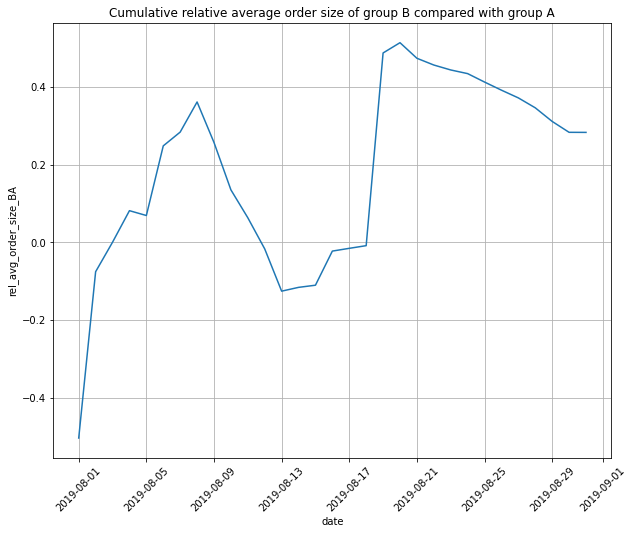

In [56]:
fig, ax = plt.subplots()
line_plotA = sns.lineplot(x = 'date', y = 'rel_avg_order_size_BA',data = rel_avg_order_size_BA)
fig1 = fig.set_size_inches(10,8)
x1 = line_plotA.set_title("Cumulative relative average order size of group B compared with group A")
fig2 = plt.xticks(rotation=45)
fig3 = plt.grid()
plt.show()

We observe significant fluctuations in group B cumulatve average order size compared with that of group A.  
These differences can be attributed to the outliers, the test not being stabilized or both.  
We will have to dig deeper and remove outliers (below).

## Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference.

The conversion rates is the number of order divided by the number of visits.  
Again, we will aggregate all data by day so we can divide the number of visits by the number of orders and receive unified conversion rates.

In [57]:
visitsA = visits[visits['group'] == 'A'].sort_values(by=['date']).reset_index()
visitsB = visits[visits['group'] == 'B'].sort_values(by=['date']).reset_index()

In [58]:
visitsA.head()
visitsB.head()

,index,date,group,visits,day_of_week,week
0,0,2019-08-01,A,719,3,2019-08-01
1,1,2019-08-02,A,619,4,2019-08-01
2,2,2019-08-03,A,507,5,2019-08-01
3,3,2019-08-04,A,717,6,2019-08-01
4,4,2019-08-05,A,756,0,2019-08-01


,index,date,group,visits,day_of_week,week
0,31,2019-08-01,B,713,3,2019-08-01
1,32,2019-08-02,B,581,4,2019-08-01
2,33,2019-08-03,B,509,5,2019-08-01
3,34,2019-08-04,B,770,6,2019-08-01
4,35,2019-08-05,B,707,0,2019-08-01


In [59]:
ordersA_per_day = ordersA.groupby(['date']).count().reset_index()[['date', 'transactionId']]
ordersB_per_day = ordersB.groupby(['date']).count().reset_index()[['date', 'transactionId']]

In [60]:
ordersA_per_day.columns = ['date', 'order_num']
ordersB_per_day.columns = ['date', 'order_num']

In [61]:
ordersA_per_day.head()
ordersB_per_day.head()

,date,order_num
0,2019-08-01,23
1,2019-08-02,19
2,2019-08-03,24
3,2019-08-04,11
4,2019-08-05,22


,date,order_num
0,2019-08-01,17
1,2019-08-02,23
2,2019-08-03,14
3,2019-08-04,14
4,2019-08-05,21


In [62]:
visitsA = visitsA.merge(ordersA_per_day, how='inner', on='date')
visitsB = visitsB.merge(ordersB_per_day, how='inner', on='date')

In [63]:
visitsA ['conversion'] = visitsA ['order_num'] / visitsA ['visits'] 
visitsB ['conversion'] = visitsB ['order_num'] / visitsB ['visits'] 

In [64]:
visitsA.head()
visitsB.head()

,index,date,group,visits,day_of_week,week,order_num,conversion
0,0,2019-08-01,A,719,3,2019-08-01,23,0.031989
1,1,2019-08-02,A,619,4,2019-08-01,19,0.030695
2,2,2019-08-03,A,507,5,2019-08-01,24,0.047337
3,3,2019-08-04,A,717,6,2019-08-01,11,0.015342
4,4,2019-08-05,A,756,0,2019-08-01,22,0.029101


,index,date,group,visits,day_of_week,week,order_num,conversion
0,31,2019-08-01,B,713,3,2019-08-01,17,0.023843
1,32,2019-08-02,B,581,4,2019-08-01,23,0.039587
2,33,2019-08-03,B,509,5,2019-08-01,14,0.027505
3,34,2019-08-04,B,770,6,2019-08-01,14,0.018182
4,35,2019-08-05,B,707,0,2019-08-01,21,0.029703


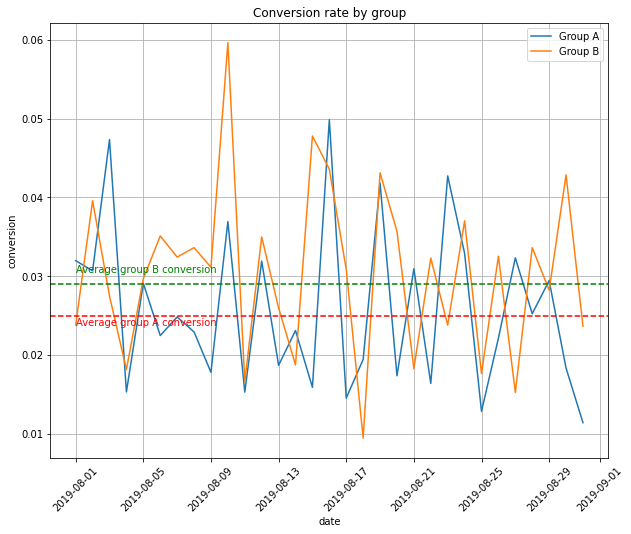

In [65]:
fig, ax = plt.subplots()
line_plotA = sns.lineplot(x = 'date', y = 'conversion',data = visitsA, label = 'Group A')
line_plotB = sns.lineplot(x = 'date', y = 'conversion',data = visitsB, label = 'Group B')
fig1 = fig.set_size_inches(10,8)
x1 = line_plotA.set_title("Conversion rate by group")
fig2 = plt.xticks(rotation=45)
fig3 = plt.grid()

#Validate against overall averaged conversion rates - as a sanity check...:

x2 = ax.axhline(len(ordersA) / visitsA.visits.sum(), ls='--', c='red')
x3 = ax.text(ordersA.date.min(),0.95 * len(ordersA) / visitsA.visits.sum(),"Average group A conversion", c='red')
x4 = ax.axhline(len(ordersB) / visitsB.visits.sum(), ls='--', c='green')
x5 = ax.text(ordersA.date.min(),1.05 * len(ordersB) / visitsB.visits.sum(),"Average group B conversion", c='green')

plt.show()

In [66]:
print('average convergance rate for group A =',len(ordersA) / visitsA.visits.sum())

average convergance rate for group A = 0.02497865072587532


In [67]:
print('average convergance rate for group B =',len(ordersB) / visitsB.visits.sum())

average convergance rate for group B = 0.02897018397124128


In [68]:
print('Total average convergance rate =',len(orders) / visits.visits.sum())

Total average convergance rate = 0.026983958355465847


We can see that:
* The conversion rates are not very high.
* Overall, group B appears more promising than group A.
* They are highly fluctuating (due to both orders and revenue being highly fluctuating, see below).  
* There are peaks (seasonality, similar but not identical dynamics among groups) that could be attributed to the fact that Fridays and Saturdays present considerably less visits while Sundays present the most visits.
  
We cannot conclude that any specific group is more promising.

Examine revenue:

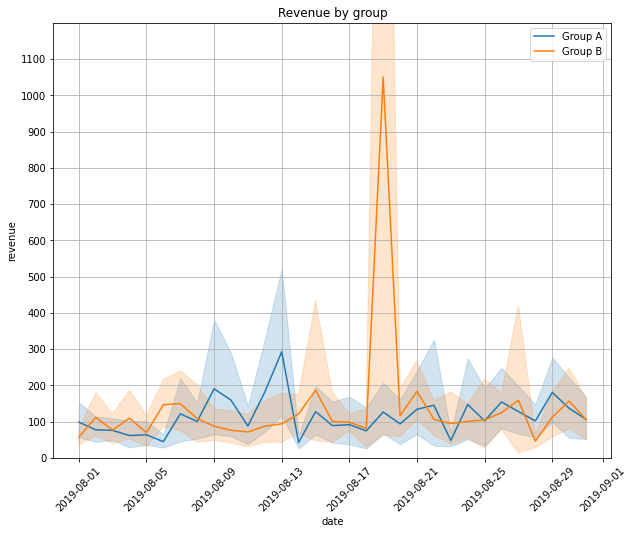

In [69]:
fig, ax = plt.subplots()
line_plotA = sns.lineplot(x = 'date', y = 'revenue',data = ordersA, label = 'Group A')
line_plotB = sns.lineplot(x = 'date', y = 'revenue',data = ordersB, label = 'Group B')
fig1 = fig.set_size_inches(10,8)
x1 = line_plotA.set_title("Revenue by group")
y1 = ax.set_ylim(0,1200)
y2 = ax.set_yticks(range(0,1200,100))
fig2 = plt.xticks(rotation=45)
fig3 = plt.grid()
plt.show()

In [70]:
#Checking peak
ordersB.loc[ordersB['date'] == '2019-08-19', ['revenue']].mean()

revenue    1050.709595
dtype: float32

########################################################

**Remark:**  
There is a size difference between the groups that results mainly from the traffic routing error.  445 for group A versus 528 for group B.  
This situation is not ideal.  
We should strive for identical group sizes.  
This could be a strong argument to continue the test.  
However, we do not see a large difference in orders per user, so perhaps the sample sizes are large enough...

In [71]:
len(ordersA)
ordersA.visitorId.nunique()
orders_per_userA = len(ordersA) / ordersA.visitorId.nunique()
orders_per_userA

len(ordersB)
ordersB.visitorId.nunique()
orders_per_userB = len(ordersB) / ordersB.visitorId.nunique()
orders_per_userB

468

445

1.051685393258427

548

528

1.0378787878787878

########################################################

## Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.

In [72]:
orders_per_user = orders.groupby(['visitorId']).nunique()[['transactionId']].reset_index().sort_values(by='transactionId', ascending = False)

#Local version
#orders_per_user = orders.groupby(['visitorId']).nunique().reset_index()#[['visitorId', 'transactionId']].sort_values(by='transactionId', ascending = False)

In [73]:
orders_per_user.head()

,visitorId,transactionId
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3


In [74]:
orders_per_user.columns=['visitorId','order_num']

In [75]:
orders_per_user.head()

,visitorId,order_num
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3


In [76]:
print(np.percentile(orders_per_user['order_num'], [95, 99]))

[1. 2.]


The amount of data to be deducted (in %) if we use this percentile:

In [77]:
len(orders_per_user[orders_per_user['order_num'] > np.percentile(orders_per_user['order_num'], 95)])/len(orders_per_user)
len(orders_per_user[orders_per_user['order_num'] > np.percentile(orders_per_user['order_num'], 99)])/len(orders_per_user)

0.03699897225077081

0.007194244604316547

And in absolute entries:

In [78]:
len(orders_per_user[orders_per_user['order_num'] > np.percentile(orders_per_user['order_num'], 95)])
len(orders_per_user[orders_per_user['order_num'] > np.percentile(orders_per_user['order_num'], 99)])

36

7

Let's graph the data:

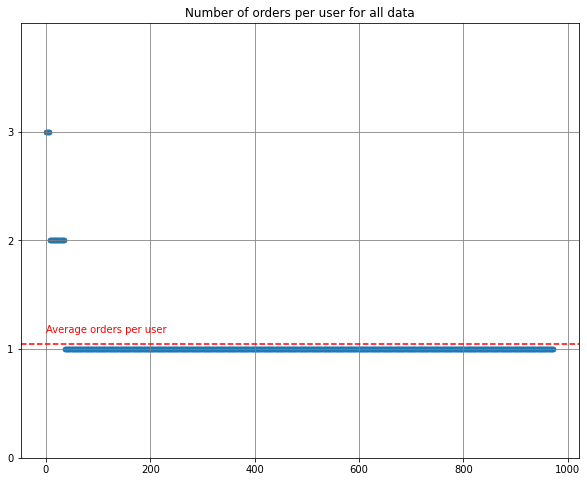

In [79]:
x_values = pd.Series(range(0,len(orders_per_user['order_num'])))
fig, ax = plt.subplots()
#line_plotA = sns.scatterplot(data=orders, x=x_values, y="revenue")
line_plotA = plt.scatter(x_values, orders_per_user.order_num, s=20)
fig1 = fig.set_size_inches(10,8)
#x1 = line_plotA.set_title("Number of orders per user for all data")
x1 = plt.title("Number of orders per user for all data")
x2 = ax.axhline(orders_per_user['order_num'].mean(), ls='--', c='red')
x3 = ax.text(0,1.1 * orders_per_user['order_num'].mean(),"Average orders per user", c='red')
x4 = ax.set_ylim(0, 4)
x5 = ax.set_yticks(range(0,4,1))
fig3 = plt.grid(color='grey')
plt.show()

#https://www.pythonprogramming.in/customize-grid-color-and-style.html

Anomalies can be broadly classified into different categories:

* Outliers: Short/small anomalous patterns that appear in a non-systematic way in data collection.
* Change in Events: Systematic or sudden change from the previous normal behavior.
* Drifts: Slow, undirectional, long-term change in the data.

There are established methods to properly define an anomally such as:  
1. Isolation Forest
2. Local Outlier Factor
3. Robust Covariance
4. One-Class Support Vector Machine (SVM)
5. One-Class SVM (SGD)
...

They are mostly implemented using the Scikit-learn package.  
Unfortunately, we still did not study this material and the relevant methods so I currently cannot implement them.

I can use the statistical Z-score or the like.  
Here, (since the question asked...😉) I intend to choose between the 95 and 99th percentiles.  
After examining how many users exceed these percentiles, it makes sense to me to include 2 orders per user but not 3. So I will use the 99th%.

https://towardsdatascience.com/5-anomaly-detection-algorithms-every-data-scientist-should-know-b36c3605ea16  
https://en.wikipedia.org/wiki/Anomaly_detection  

## Plot a scatter chart of order prices.

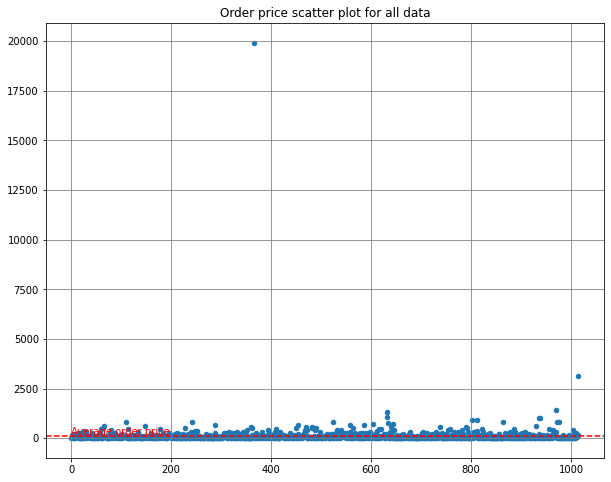

In [80]:
x_values = pd.Series(range(0,len(orders['revenue'])))
fig, ax = plt.subplots()
#line_plotA = sns.scatterplot(data=orders, x=x_values, y="revenue")
line_plotA = plt.scatter(x_values, orders.revenue, s=20)
fig1 = fig.set_size_inches(10,8)
#x1 = line_plotA.set_title("Order price scatter plot for all data")
x1 = plt.title("Order price scatter plot for all data")
x2 = ax.axhline(orders['revenue'].mean(), ls='--', c='red')
x3 = ax.text(0,1.3 * orders['revenue'].mean(),"Average order price", c='red')
fig3 = plt.grid(color='grey')
plt.show()

#https://www.pythonprogramming.in/customize-grid-color-and-style.html

We are losing most of the interesting details due to few outliers.  
So, let's 'break' the y-axis into two portions.  
Use the top (ax1) for the outliers and the bottom (ax2) for the majority of our data.  
(Another option is to use gridspec...)

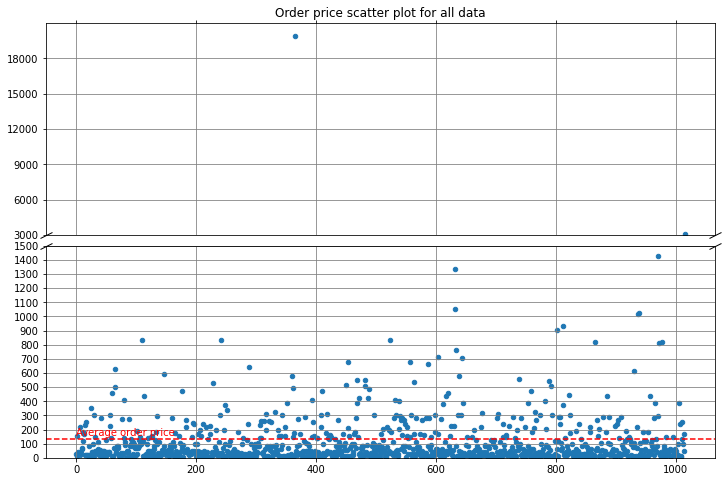

In [81]:
x_values = pd.Series(range(0,len(orders['revenue'])))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.subplots_adjust(hspace=0.05)  # adjust space between axes

# plot the same data on both axes
#line_plotA1 = sns.scatterplot(ax=ax1,data=orders, x=x_values, y="revenue")
#line_plotA2 = sns.scatterplot(ax=ax2,data=orders, x=x_values, y="revenue")

line_plotA1 = ax1.scatter(x_values, orders.revenue, s=20)
line_plotA2 = ax2.scatter(x_values, orders.revenue, s=20)

# zoom-in / limit the view to different portions of the data
x1 = ax1.set_ylim(3000, 21000)  # outliers only
x11 = ax1.set_yticks(range(3000,21000,3000))
x2 = ax2.set_ylim(0, 1500)  # most of the data
x21 = ax2.set_yticks(range(0,1600,100))

# hide the spines between ax1 and ax2
#x3 = ax1.spines.bottom.set_visible(False)
#x4 = ax2.spines.top.set_visible(False)
x5 = ax1.xaxis.tick_top()
x6 = ax1.tick_params(labeltop=False)  # don't put tick labels at the top
x7 = ax2.xaxis.tick_bottom()
x71 = ax2.axhline(orders['revenue'].mean(), ls='--', c='red')
x72 = ax2.text(0,1.2 * orders['revenue'].mean(),"Average order price", c='red')

# Now, cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the axes size or scale
# Finally, we need to disable clipping.

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
x8=ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
x9=ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax1.grid(color='grey')
ax2.grid(color='grey')
x10 = ax1.set_title("Order price scatter plot for all data")

plt.show()

# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html
# adjusted to fit seaborn.


**Remark:**  
Notice the broken y axis and the uneven scaling used for the outliers.

In [82]:
orders.sort_values(by='revenue', ascending=False).head(10)

,transactionId,visitorId,date,revenue,group,day_of_week,week,first_visit_A,first_visit_B
425,590470918,1920142716,2019-08-19,19920.400391,B,0,2019-08-15,NaT,2019-08-19
1196,3936777065,2108080724,2019-08-15,3120.100098,B,3,2019-08-15,NaT,2019-08-15
1136,666610489,1307669133,2019-08-13,1425.800049,A,1,2019-08-08,2019-08-13,NaT
744,3668308183,888512513,2019-08-27,1335.599976,B,1,2019-08-22,NaT,2019-08-27
743,3603576309,4133034833,2019-08-09,1050.000000,A,4,2019-08-08,2019-08-09,NaT
1103,1348774318,1164614297,2019-08-12,1025.800049,A,0,2019-08-08,2019-08-12,NaT
1099,316924019,148427295,2019-08-12,1015.900024,A,0,2019-08-08,2019-08-12,NaT
949,1347999392,887908475,2019-08-21,930.000000,A,2,2019-08-15,2019-08-21,NaT
940,2420050534,4003628586,2019-08-08,905.799988,B,3,2019-08-08,NaT,2019-08-08
613,4071177889,3931967268,2019-08-07,830.299988,B,2,2019-08-01,NaT,2019-08-07


## Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.

In [83]:
np.percentile(orders['revenue'], 95)
np.percentile(orders['revenue'], 99)

414.2750015258789

830.2999877929688

In [84]:
len(orders[orders['revenue'] > np.percentile(orders['revenue'], 95)])/len(orders)
len(orders[orders['revenue'] > np.percentile(orders['revenue'], 99)])/len(orders)

0.05019685039370079

0.008858267716535433

Here, excluding less than 1% seems way too much for me (use 830 as the threshold).  
So, I will use the 95th% (414) as the cut-off criterion for an order price.  

## Find the statistical significance of the difference in conversion between the groups using the raw data.

Since the groups are not identical in size, we better work with the proportions (conversions) rather than with the absolute numbers.

In [85]:
def compare_proportions(successesA,trialsA, successesB,trialsB, alpha=0.05):
    #proportion for success in the first, second and total groups
    
    pA = successesA/trialsA
    print('Success proportion of group A is:', pA, '\n')
    
    pB = successesB/trialsB
    print('Success proportion of group B is:', pB, '\n')

    p_combined = (successesA + successesB) / (trialsA + trialsB) 

    print('Success proportion of all data combined is:', p_combined, '\n')

    difference = pA - pB
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trialsA + 1/trialsB))
    print('Z value is:', z_value, '\n')

    distr = stats.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-value: ', p_value)

In [86]:
successesA = len(ordersA)
print('Group A successes:', successesA)

successesB = len(ordersB)
print('Group B successes:', successesB)

trialsA = visitsA.visits.sum()
print('Group A trials:', trialsA)

trialsB = visitsB.visits.sum()
print('Group B trials:', trialsB)


Group A successes: 468
Group B successes: 548
Group A trials: 18736
Group B trials: 18916


In [87]:
compare_proportions(successesA,trialsA, successesB,trialsB, alpha=0.05)

Success proportion of group A is: 0.02497865072587532 

Success proportion of group B is: 0.02897018397124128 

Success proportion of all data combined is: 0.026983958355465847 

Z value is: -2.3899344431697442 

p-value:  0.016851380434703023


Double checking against the built in option:

In [88]:
stat, pval = proportions_ztest([successesA,successesB], [trialsA,trialsB])
print('{0:0.3f}'.format(pval))

0.017


Let us examine graphically:

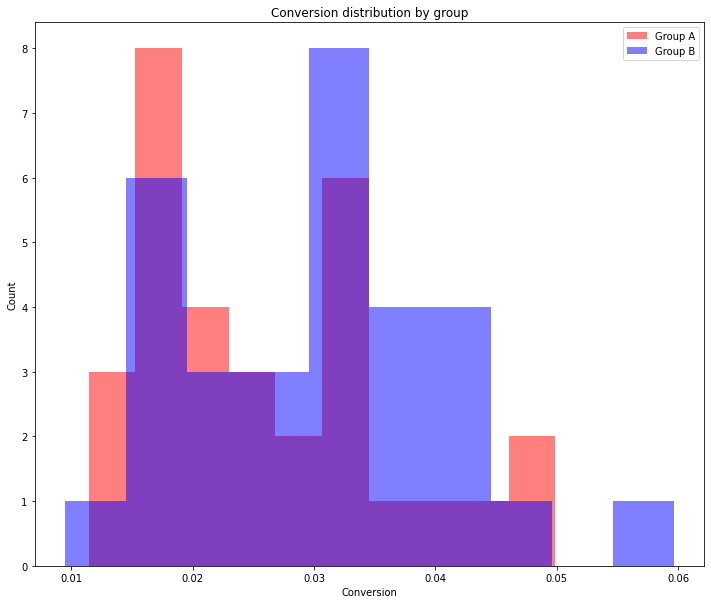

In [89]:
fig, ax = plt.subplots()
fig.set_size_inches(12,10)
x1 = plt.hist(visitsA['conversion'], alpha=0.5, bins=10, color = 'red', label='Group A')
x2 = plt.hist(visitsB['conversion'], alpha=0.5, bins=10, color = 'blue', label='Group B')
fig1 = plt.legend(loc='upper right')
fig2 = plt.title("Conversion distribution by group")
x3 = ax.set_xlabel('Conversion')
x4 = ax.set_ylabel('Count')
plt.show()

Since the p value is very low (much lower than 0.05), we cannot accept the null hypothesis that the two groups have identical proportions.  
That is, we assume that the two groups are different.  
In other words, the conversion rates are not similar (we already saw differences above in section 7.4 ...).  
In this case group B appears more promising.

## Find the statistical significance of the difference in average order size between the groups using the raw data.

First, we must check if the samples are normal.
In this manner we will know whether to use a paramteric or non-paramteric test.  
To this end, we will use the Wilk-Shapiro normality test.  
Then, we will route the test to the appropriate channel:

In [90]:
def compare_samples(sample1,sample2,alpha=0.05):
    #checking normality
    sample1=sample1.dropna()
    sample2=sample2.dropna()
    
    #checking normality for sample 1:
    stat1, p1_norm=stats.shapiro(sample1) # check sample 1 for normality
    if p1_norm > alpha:
        print('sample 1 is normal\n')
    else:
        print('sample 1 is not normal\n')
    
    #checking normality for sample 2:
    stat2, p2_norm=stats.shapiro(sample2) # check sample 2 for normality
    if p2_norm > alpha:
        print('sample 2 is normal\n')
    else:
        print('sample 2 is not normal\n')
     
    if p1_norm > alpha and p2_norm > alpha: # only if both samples are normal - we will proceed with a t-test
                                            # for t-test -  check the equality of variances (Levene test)
        print('Both samples are normal, checking for equality of variances using the Levene test\n')
        statslev,p_levene=stats.levene(sample1, sample2)
        if p_levene < alpha:                # variances are not equal, perform non-equal var. t-test
            print('The variances are not equal\n')
            statist,p_value=stats.ttest_ind(sample1, sample2,equal_var=False)
        else:                               # variances are equal, perform equal var. t-test
            print('The variances are equal\n')
            statist,p_value=stats.ttest_ind(sample1, sample2,equal_var=True) 
    else:                                   # if not both samples are normal, proceed with a mann-whitney test
        print('Using the Mann-Whitney test\n')
        statist,p_value=stats.mannwhitneyu(sample1, sample2)
    
    print('The p value is:\n', p_value,'\n')
    if p_value < alpha:
        print('Reject H0, the distributions are different')
    else:
        print('Fail to Reject H0, we cannot exclude the possibility that the distributions are similar')
    

In [91]:
compare_samples(ordersA['revenue'],ordersB['revenue'],alpha=0.05)

sample 1 is not normal

sample 2 is not normal

Using the Mann-Whitney test

The p value is:
 0.8622329690015668 

Fail to Reject H0, we cannot exclude the possibility that the distributions are similar


## Find the statistical significance of the difference in conversion between the groups using the filtered data.

### Define filtered dataframes using decided criteria.

First, we will filter by number of orders per user:

In [92]:
np.percentile(orders_per_user['order_num'], 99)

2.0

In [93]:
remove_by_order = orders_per_user[orders_per_user['order_num'] > np.percentile(orders_per_user['order_num'], 99)]
remove_by_order

,visitorId,order_num
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3


In [94]:
orders_clean = orders[~orders['visitorId'].isin(remove_by_order['visitorId'])]

In [95]:
examine(orders_clean)


***************
 head:
    transactionId   visitorId       date     revenue group  day_of_week  \
0  3667963787     3312258926 2019-08-15  30.400000   B     3             
1  2804400009     3642806036 2019-08-15  15.200000   B     3             
3  3797467345     1196621759 2019-08-15  155.100006  B     3             
4  2282983706     2322279887 2019-08-15  40.500000   B     3             
5  182168103      935554773  2019-08-15  35.000000   B     3             

        week first_visit_A first_visit_B  
0 2019-08-15 NaT           2019-08-15     
1 2019-08-15 NaT           2019-08-15     
3 2019-08-15 NaT           2019-08-15     
4 2019-08-15 NaT           2019-08-15     
5 2019-08-15 NaT           2019-08-15     

***************
 tail:
       transactionId   visitorId       date      revenue group  day_of_week  \
1191  3592955527     608641596  2019-08-14  255.699997   B     2             
1192  2662137336     3733762160 2019-08-14  100.800003   B     2             
1193  2203539

In [96]:
np.percentile(orders['revenue'], 95)

414.2750015258789

In [97]:
orders_clean = orders_clean[orders_clean['revenue'] < np.percentile(orders['revenue'], 95)]

In [98]:
examine(orders_clean)


***************
 head:
    transactionId   visitorId       date     revenue group  day_of_week  \
0  3667963787     3312258926 2019-08-15  30.400000   B     3             
1  2804400009     3642806036 2019-08-15  15.200000   B     3             
3  3797467345     1196621759 2019-08-15  155.100006  B     3             
4  2282983706     2322279887 2019-08-15  40.500000   B     3             
5  182168103      935554773  2019-08-15  35.000000   B     3             

        week first_visit_A first_visit_B  
0 2019-08-15 NaT           2019-08-15     
1 2019-08-15 NaT           2019-08-15     
3 2019-08-15 NaT           2019-08-15     
4 2019-08-15 NaT           2019-08-15     
5 2019-08-15 NaT           2019-08-15     

***************
 tail:
       transactionId   visitorId       date     revenue group  day_of_week  \
1190  38478481       1197745035 2019-08-14  135.300003  B     2             
1191  3592955527     608641596  2019-08-14  255.699997  B     2             
1192  2662137336

The removal of numerous orders users reduced our data from 1016 to 995 entries.  
The removal of anomalous (very large) orders further reduced our data to 944 entries.  
  
Unfortunately, we have no way of cleaning the visits dataframe as we cannot specifically identify the anomalous users in it. This is a shame because it damages the quality of the results.  

Nevertheless, we are considering only 1016-944 = 72 entries.  
Even if all these users would have made 5 transactions (the most we saw above), which is very unlikely, we would have received 360 visits.  
This is ~0.5 of the daily visits median (624.5 - see above).  
This means that the resulting error is negligible.

### Repeat the calculation for the clean data.

In [99]:
ordersA_clean = orders_clean[orders_clean['group'] == 'A'].sort_values(by=['date','transactionId']).reset_index()
ordersB_clean = orders_clean[orders_clean['group'] == 'B'].sort_values(by=['date','transactionId']).reset_index()

In [100]:
ordersA_clean.head()
ordersB_clean.head()

,index,transactionId,visitorId,date,revenue,group,day_of_week,week,first_visit_A,first_visit_B
0,72,477940151,1422773200,2019-08-01,15.800000,A,3,2019-08-01,2019-08-01,NaT
1,170,617930325,2785040378,2019-08-01,55.799999,A,3,2019-08-01,2019-08-01,NaT
2,155,891673177,572335325,2019-08-01,60.799999,A,3,2019-08-01,2019-08-01,NaT
3,55,1144701458,1143609305,2019-08-01,45.299999,A,3,2019-08-01,2019-08-01,NaT
4,96,1170105516,2706377257,2019-08-01,140.800003,A,3,2019-08-01,2019-08-01,NaT


,index,transactionId,visitorId,date,revenue,group,day_of_week,week,first_visit_A,first_visit_B
0,66,4919758,1217561296,2019-08-01,40.200001,B,3,2019-08-01,NaT,2019-08-01
1,100,804934578,1738775963,2019-08-01,50.799999,B,3,2019-08-01,NaT,2019-08-01
2,142,854120002,544963298,2019-08-01,25.900000,B,3,2019-08-01,NaT,2019-08-01
3,138,1403947326,1075551409,2019-08-01,10.000000,B,3,2019-08-01,NaT,2019-08-01
4,136,1578920557,680119828,2019-08-01,10.600000,B,3,2019-08-01,NaT,2019-08-01


In [101]:
ordersA_clean ['cum_revenue'] = ordersA_clean['revenue'].cumsum()
ordersB_clean ['cum_revenue'] = ordersB_clean['revenue'].cumsum()

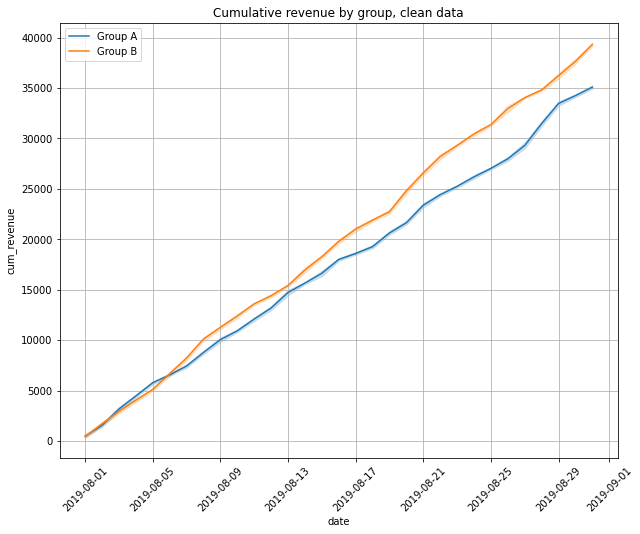

In [102]:
fig, ax = plt.subplots()
line_plotA = sns.lineplot(x = 'date', y = 'cum_revenue',data = ordersA_clean, label = 'Group A')
line_plotB = sns.lineplot(x = 'date', y = 'cum_revenue',data = ordersB_clean, label = 'Group B')
fig1 = fig.set_size_inches(10,8)
x1 = line_plotA.set_title("Cumulative revenue by group, clean data")
fig2 = plt.xticks(rotation=45)
fig3 = plt.grid()
plt.show()

#https://www.geeksforgeeks.org/rotate-axis-tick-labels-in-seaborn-and-matplotlib/

We can see that group B is gaining the advantage over group A.  
The trends are much cleaner now that the outliers are gone...

In [103]:
ordersA_clean['cum_orders'] = ordersA_clean.index+1
ordersB_clean['cum_orders'] = ordersB_clean.index+1

In [104]:
ordersA_clean['avg_order_size'] = ordersA_clean ['cum_revenue'] / ordersA_clean['cum_orders']
ordersB_clean['avg_order_size'] = ordersB_clean ['cum_revenue'] / ordersB_clean['cum_orders']

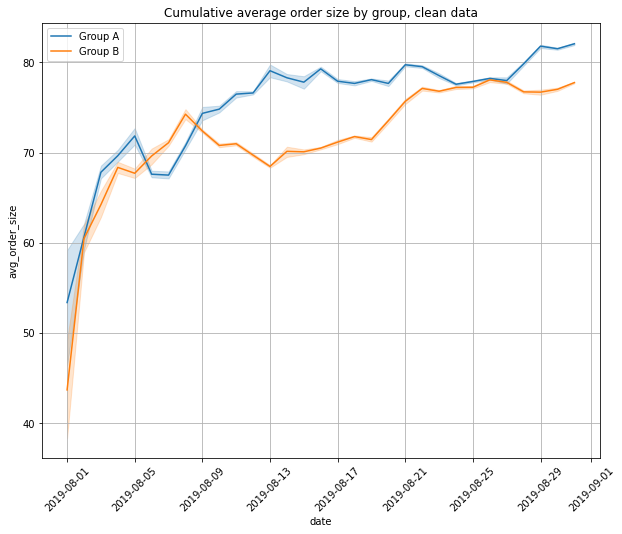

In [105]:
fig, ax = plt.subplots()
line_plotA = sns.lineplot(x = 'date', y = 'avg_order_size',data = ordersA_clean, label = 'Group A')
line_plotB = sns.lineplot(x = 'date', y = 'avg_order_size',data = ordersB_clean, label = 'Group B')
fig1 = fig.set_size_inches(10,8)
x1 = line_plotA.set_title("Cumulative average order size by group, clean data")
fig2 = plt.xticks(rotation=45)
fig3 = plt.grid()
plt.show()

#https://www.geeksforgeeks.org/rotate-axis-tick-labels-in-seaborn-and-matplotlib/

We can see that in terms of order size, the matrix did not stabilize yet.  
We have fluctuating data.  
Furthermore, after outlier removal, group A appears more promising than group B.

In [106]:
ordersA_by_day_clean = ordersA_clean.groupby(['date']).mean().reset_index()[['date', 'avg_order_size']]
ordersB_by_day_clean = ordersB_clean.groupby(['date']).mean().reset_index()[['date', 'avg_order_size']]

In [107]:
rel_avg_order_size_BA_clean = ordersA_by_day_clean.merge(ordersB_by_day_clean, how='inner', on='date', suffixes = ['_A', '_B'])
rel_avg_order_size_BA_clean ['rel_avg_order_size_BA'] = rel_avg_order_size_BA_clean ['avg_order_size_B'] / rel_avg_order_size_BA_clean ['avg_order_size_A'] - 1.0

In [108]:
rel_avg_order_size_BA_clean.head()

,date,avg_order_size_A,avg_order_size_B,rel_avg_order_size_BA
0,2019-08-01,53.393133,43.712173,-0.181315
1,2019-08-02,60.665859,60.489793,-0.002902
2,2019-08-03,67.833253,64.246082,-0.052882
3,2019-08-04,69.667534,68.369610,-0.018630
4,2019-08-05,71.855192,67.720026,-0.057549


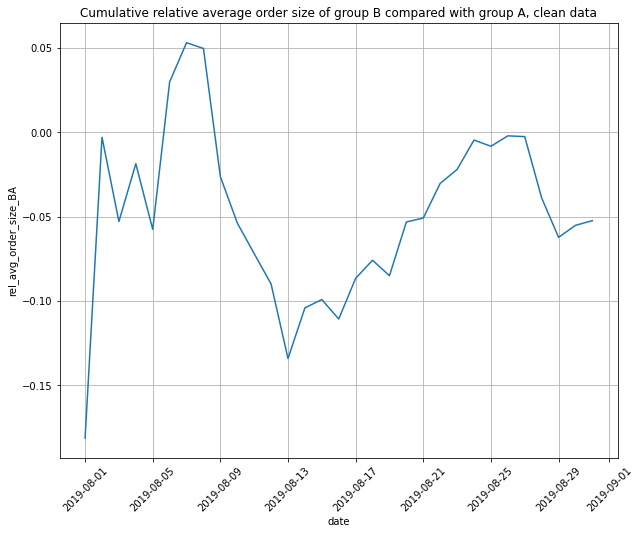

In [109]:
fig, ax = plt.subplots()
line_plotA = sns.lineplot(x = 'date', y = 'rel_avg_order_size_BA',data = rel_avg_order_size_BA_clean)
fig1 = fig.set_size_inches(10,8)
x1 = line_plotA.set_title("Cumulative relative average order size of group B compared with group A, clean data")
fig2 = plt.xticks(rotation=45)
fig3 = plt.grid()
plt.show()

We can see that:
* The data has not stabilized yet.
* Group B appears less promising than group A most of the time.
* The differences between the groups appear to be converging to very small values (about 5% in favor of group A).    

In [110]:
ordersA_per_day_clean = ordersA_clean.groupby(['date']).count().reset_index()[['date', 'transactionId']]
ordersB_per_day_clean = ordersB_clean.groupby(['date']).count().reset_index()[['date', 'transactionId']]

In [111]:
ordersA_per_day_clean.columns = ['date', 'order_num']
ordersB_per_day_clean.columns = ['date', 'order_num']

In [112]:
visitsA_clean = visits[visits['group'] == 'A'].sort_values(by=['date']).reset_index()
visitsB_clean = visits[visits['group'] == 'B'].sort_values(by=['date']).reset_index()

In [113]:
visitsA_clean = visitsA_clean.merge(ordersA_per_day_clean, how='inner', on='date')
visitsB_clean = visitsB_clean.merge(ordersB_per_day_clean, how='inner', on='date')

In [114]:
visitsA_clean ['conversion'] = visitsA_clean ['order_num'] / visitsA_clean ['visits'] 
visitsB_clean ['conversion'] = visitsB_clean ['order_num'] / visitsB_clean ['visits'] 

In [115]:
visitsA_clean.head()
visitsB_clean.head()

,index,date,group,visits,day_of_week,week,order_num,conversion
0,0,2019-08-01,A,719,3,2019-08-01,16,0.022253
1,1,2019-08-02,A,619,4,2019-08-01,18,0.029079
2,2,2019-08-03,A,507,5,2019-08-01,24,0.047337
3,3,2019-08-04,A,717,6,2019-08-01,11,0.015342
4,4,2019-08-05,A,756,0,2019-08-01,22,0.029101


,index,date,group,visits,day_of_week,week,order_num,conversion
0,31,2019-08-01,B,713,3,2019-08-01,17,0.023843
1,32,2019-08-02,B,581,4,2019-08-01,21,0.036145
2,33,2019-08-03,B,509,5,2019-08-01,14,0.027505
3,34,2019-08-04,B,770,6,2019-08-01,13,0.016883
4,35,2019-08-05,B,707,0,2019-08-01,20,0.028289


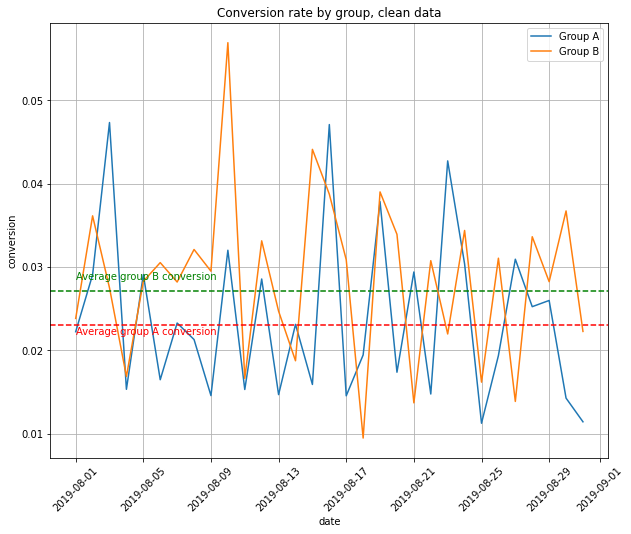

In [116]:
fig, ax = plt.subplots()
line_plotA = sns.lineplot(x = 'date', y = 'conversion',data = visitsA_clean, label = 'Group A')
line_plotB = sns.lineplot(x = 'date', y = 'conversion',data = visitsB_clean, label = 'Group B')
fig1 = fig.set_size_inches(10,8)
x1 = line_plotA.set_title("Conversion rate by group, clean data")
fig2 = plt.xticks(rotation=45)
fig3 = plt.grid()

#Validate against overall averaged conversion rates - as a sanity check...:

x2 = ax.axhline(len(ordersA_clean) / visitsA_clean.visits.sum(), ls='--', c='red')
x3 = ax.text(ordersA_clean.date.min(),0.95 * len(ordersA_clean) / visitsA_clean.visits.sum(),"Average group A conversion", c='red')
x4 = ax.axhline(len(ordersB_clean) / visitsB_clean.visits.sum(), ls='--', c='green')
x5 = ax.text(ordersA_clean.date.min(),1.05 * len(ordersB_clean) / visitsB_clean.visits.sum(),"Average group B conversion", c='green')

plt.show()

In [117]:
print('average convergance rate for group A,cleaned =',len(ordersA_clean) / visitsA_clean.visits.sum())
print('average convergance rate for group B,cleaned  =',len(ordersB_clean) / visitsB_clean.visits.sum())
print('Total average convergance rate,cleaned =',len(orders_clean) / visits.visits.sum())

average convergance rate for group A,cleaned = 0.023003842869342442
average convergance rate for group B,cleaned  = 0.027119898498625502
Total average convergance rate,cleaned = 0.025071709338149367


The conversion differences between the cleaned groups reduced compared to those between the raw groups.  
This is reasonable and expectable.

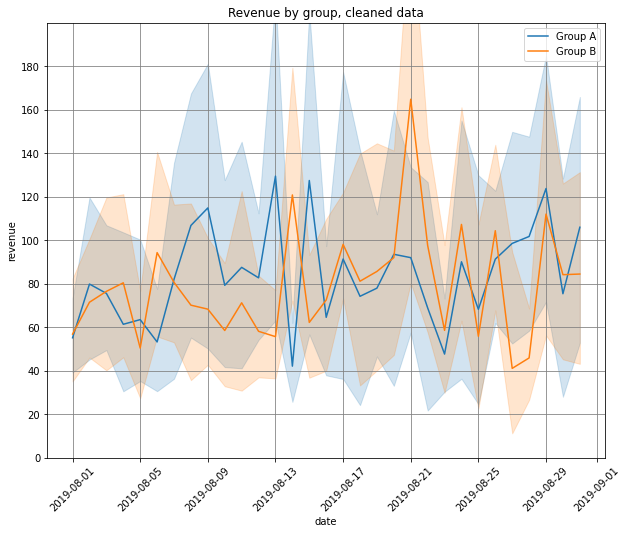

In [118]:
fig, ax = plt.subplots()
line_plotA = sns.lineplot(x = 'date', y = 'revenue',data = ordersA_clean, label = 'Group A')
line_plotB = sns.lineplot(x = 'date', y = 'revenue',data = ordersB_clean, label = 'Group B')
fig1 = fig.set_size_inches(10,8)
x1 = line_plotA.set_title("Revenue by group, cleaned data")
y1 = ax.set_ylim(0,200)
y2 = ax.set_yticks(range(0,200,20))
fig2 = plt.xticks(rotation=45)
fig3 = plt.grid(color='grey')
plt.show()

We can see that the daily revenue differences have significantly reduced.  
Again, with no clear leading group.

### Repeat test using filtered dataframes.

In [119]:
successesA = len(ordersA_clean)
print('Group A successes:', successesA)

successesB = len(ordersB_clean)
print('Group B successes:', successesB)

trialsA = visitsA_clean.visits.sum()
print('Group A trials:', trialsA)

trialsB = visitsB_clean.visits.sum()
print('Group B trials:', trialsB)

Group A successes: 431
Group B successes: 513
Group A trials: 18736
Group B trials: 18916


As expected, visits numbers did not change but orders numbers were reduced.

In [120]:
# compare_proportions(successesA,trialsA, successesB,trialsB, alpha=0.05)

In [121]:
stat, pval = proportions_ztest([successesA,successesB], [trialsA,trialsB])
print('{0:0.3f}'.format(pval))

0.011


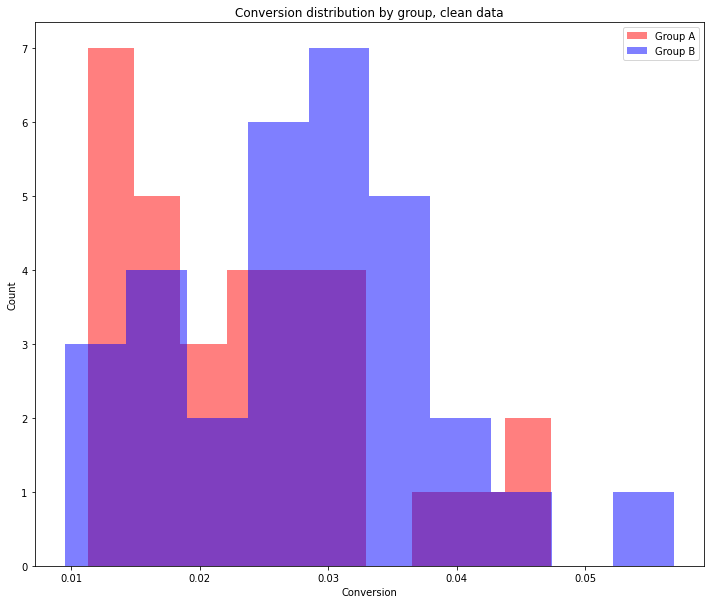

In [122]:
fig, ax = plt.subplots()
fig.set_size_inches(12,10)
x1 = plt.hist(visitsA_clean['conversion'], alpha=0.5, bins=10, color = 'red', label='Group A')
x2 = plt.hist(visitsB_clean['conversion'], alpha=0.5, bins=10, color = 'blue', label='Group B')
fig1 = plt.legend(loc='upper right')
fig2 = plt.title("Conversion distribution by group, clean data")
x3 = ax.set_xlabel('Conversion')
x4 = ax.set_ylabel('Count')
plt.show()

Again, the p value is very low (even lower than before - 0.011 vs. 0.017).  
The conversion rates are not similar.  
In the cleaned data, group B appears even more promising compared to group A.  
The statistical test conclusions did not change.

## Find the statistical significance of the difference in average order size between the groups using the filtered data.

In [123]:
compare_samples(ordersA_clean['revenue'],ordersB_clean['revenue'],alpha=0.05)

sample 1 is not normal

sample 2 is not normal

Using the Mann-Whitney test

The p value is:
 0.6382033726359018 

Fail to Reject H0, we cannot exclude the possibility that the distributions are similar


This test results did not change also.  
It appears there are no significant average order size differences between the two cleaned groups. 

## Make a decision based on the test results.  
The possible decisions are:  
1. Stop the test, consider one of the groups the leader.  
2. Stop the test, conclude that there is no difference between the groups.  
3. Continue the test.  

Let us first review the main facts:

* We have two competing groups.  
* Group B presents statistically significant better conversion that is even more distinct when outliers are removed.  
* There is no statistically significant difference in average order size between the groups, with and without the presence of outliers..  
* The cumulative relative average order size of group B is converging to a value that is only ~5% lower than that of group A.
* Overall, group B leads in one KPI (conversion) while for another KPI (order size) the groups are similar.  

I therefore argue that the data, while not fully stabilized, is sufficiently indicutive to conclude that group B is more promising than group A and stop the test.